In [1]:
import os

In [ ]:
repo_folder_path = '~/STCarotidSeg4D'
os.chdir(repo_folder_path)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from dataclasses import dataclass

import seaborn as sns


##### Model Paths

In [4]:
save_directory = Path(f'{repo_folder_path}/notebooks/generated_images/')

In [ ]:
model_output_folder = '~/output/'
data_folder = '~/data'

In [6]:
test_images = {
    'magnitude': '{data_folder}/TestDataCorrected/2dtime_PCMRI/images',
    'velocities': '{data_folder}/TestDataCorrected/Velocities/images/'
}

test_labels = {
    'magnitude': '{data_folder}/TestDataCorrected/2dtime_PCMRI/labels/',
    'velocities': '{data_folder}/TestDataCorrected/Velocities/labels/'
}

##### Evaluation Folder Paths

In [7]:
evaluation_paths = {
    "magnitude": {
        "unetr_interp16": f"{model_output_folder}/UNETR/magnitude/Interp_16/evaluation",
        "unetr_interp32": f"{model_output_folder}/UNETR/magnitude/Interp_32/evaluation",
        "unetr_pad32_crop": f"{model_output_folder}/UNETR/magnitude/Pad_32/evaluation_crop",
        "unetr_pad32_average": f"{model_output_folder}/UNETR/magnitude/Pad_32/evaluation_avg",
        "unet3d_interp16": f"{model_output_folder}/UNet3D/magnitude/Interp_16/evaluation",
        "unet3d_interp32": f"{model_output_folder}/UNet3D/magnitude/Interp_32/evaluation",
        "unet3d_pad32_average": f"{model_output_folder}/UNet3D/magnitude/Pad_32/evaluation_avg",
        "unet3d_pad32_crop": f"{model_output_folder}/UNet3D/magnitude/Pad_32/evaluation_crop",
        "spatio_temporal_interp16": f"{model_output_folder}/SpatioTemporalTransformer/magnitude/Interp_16/evaluation",
        "spatio_temporal_interp32": f"{model_output_folder}/SpatioTemporalTransformer/magnitude/Interp_32/evaluation",
        "spatio_temporal_pad32_crop": f"{model_output_folder}/SpatioTemporalTransformer/magnitude/Pad_32/evaluation_crop",
        "spatio_temporal_pad32_average": f"{model_output_folder}/SpatioTemporalTransformer/magnitude/Pad_32/evaluation_avg",
        "unet2d": f"{model_output_folder}/UNet2D/magnitude/None_16/evaluation",
        "nnunet_2d": f"{model_output_folder}/nnUNet_results/Dataset003_MagnitudesCorrected/nnUNetTrainer__nnUNetPlans__2d/evaluation",
        "nnunet_3d_fullres": f"{model_output_folder}/nnUNet_results/Dataset003_MagnitudesCorrected/nnUNetTrainer__nnUNetPlans__3d_fullres/evaluation",
    },
    "velocities": {
        "unetr_interp16": f"{model_output_folder}/UNETR/velocities/Interp_16/evaluation",
        "unetr_interp32": f"{model_output_folder}/UNETR/velocities/Interp_32/evaluation",
        "unetr_pad32_crop": f"{model_output_folder}/UNETR/velocities/Pad_32/evaluation_crop",
        "unetr_pad32_average": f"{model_output_folder}/UNETR/velocities/Pad_32/evaluation_avg",
        "unet3d_interp16": f"{model_output_folder}/UNet3D/velocities/Interp_16/evaluation",
        "unet3d_interp16_ensemble": f"{model_output_folder}/UNet3D/velocities/Interp_16/evaluation_ensemble",
        "unet3d_interp32": f"{model_output_folder}/UNet3D/velocities/Interp_32/evaluation",
        "unet3d_interp32_ensemble": f"{model_output_folder}/UNet3D/velocities/Interp_32/evaluation_ensemble",
        "unet3d_pad32_average": f"{model_output_folder}/UNet3D/velocities/Pad_32/evaluation_avg",
        "unet3d_pad32_average_ensemble": f"{model_output_folder}/UNet3D/velocities/Pad_32/evaluation_avg_ensemble",
        "unet3d_pad32_crop": f"{model_output_folder}/UNet3D/velocities/Pad_32/evaluation_crop",
        "spatio_temporal_interp16": f"{model_output_folder}/SpatioTemporalTransformer/velocities/Interp_16/evaluation",
        "spatio_temporal_interp32": f"{model_output_folder}/SpatioTemporalTransformer/velocities/Interp_32/evaluation",
        "spatio_temporal_pad32_crop": f"{model_output_folder}/SpatioTemporalTransformer/velocities/Pad_32/evaluation_crop",
        "spatio_temporal_pad32_average": f"{model_output_folder}/SpatioTemporalTransformer/velocities/Pad_32/evaluation_avg",
        "unet2d": f"{model_output_folder}/UNet2D/velocities/None_16/evaluation",
        "nnunet_2d": f"{model_output_folder}/nnUNet_results/Dataset004_VelocitiesCorrected/nnUNetTrainer__nnUNetPlans__2d/evaluation",
        "nnunet_3d_fullres": f"{model_output_folder}/nnUNet_results/Dataset004_VelocitiesCorrected/nnUNetTrainer__nnUNetPlans__3d_fullres/evaluation",
    },
}

##### Colum Definitions

In [8]:
cols = ['Dataset',
        'Model',
        'Transform',
        'T',
        'dice_lumen',
        'hausdorff_distance_lumen',
        'max_hausdorff_distance_lumen',
        'average_contour_distance_lumen',
        'icc_lumen_diameter',
        'icc_flow_rate',
        'icc_max_velocity'
       ]

seg_cols = ['Dataset',
        'Model',
        'Transform',
        'T',
        'dice_lumen',
        'hausdorff_distance_lumen',
        'max_hausdorff_distance_lumen',
        'average_contour_distance_lumen',
       ]

icc_cols = ['Dataset',
        'Model',
        'Transform',
        'T',
        'icc_lumen_diameter',
        'icc_flow_rate',
        'icc_max_velocity'
       ]

#### Calculate Overall Validation Results

In [9]:
@dataclass
class ModelInfo:
    name: str
    transform: str
    temporal_dimension: int | None

    def __init__(self, name: str, transform: str, temporal_dimension: int | None = None):
        self.name = name
        self.transform = transform
        self.temporal_dimension = temporal_dimension

    @property
    def description(self) -> str:
        if self.transform:
            return f"{self.name} ({self.transform}, T'={self.temporal_dimension})"
        else:
            return self.name

all_models = {
    'spatio_temporal_interp16': ModelInfo('SpatioTemporalTransformer', 'Interpolate', 16),
    'spatio_temporal_interp32': ModelInfo('SpatioTemporalTransformer', 'Interpolate', 32),
    'spatio_temporal_pad32_average': ModelInfo('SpatioTemporalTransformer', 'Pad Average', 32),
    'spatio_temporal_pad32_crop': ModelInfo('SpatioTemporalTransformer', 'Pad Crop', 32),
    'unetr_interp16': ModelInfo('UNETR', 'Interpolate', 16),
    'unetr_interp16_ensemble': ModelInfo('UNETR', 'Interpolate', 16),
    'unetr_interp32': ModelInfo('UNETR', 'Interpolate', 32),
    'unetr_pad32_average': ModelInfo('UNETR', 'Pad Average', 32),
    'unetr_pad32_crop': ModelInfo('UNETR', 'Pad Crop', 32),
    'unet3d_interp16': ModelInfo('U-Net 3D', 'Interpolate', 16),
    'unet3d_interp16_ensemble': ModelInfo('U-Net 3D', 'Interpolate', 16),
    'unet3d_interp32': ModelInfo('U-Net 3D', 'Interpolate', 32),
    'unet3d_interp32_ensemble': ModelInfo('U-Net 3D', 'Interpolate', 32),
    'unet3d_pad32_average': ModelInfo('U-Net 3D', 'Pad Average', 32),
    'unet3d_pad32_average_ensemble': ModelInfo('U-Net 3D', 'Pad Average', 32),
    'unet3d_pad32_crop': ModelInfo('U-Net 3D', 'Pad Crop', 32),
    'unet2d': ModelInfo('U-Net 2D', 'None', None),
    'nnunet_2d': ModelInfo('U-Net 2D', 'nnU-Net', None),
    'nnunet_3d_fullres': ModelInfo('U-Net 3D', 'nnU-Net', 14),
}



def create_evaluation_data_frame(
    full_data_path: os.PathLike,
    results_path: os.PathLike,
    icc_lumen_diameter_dict_path: os.PathLike,
    icc_flow_rate_dict_path: os.PathLike,
    icc_max_velocity_dict_path: os.PathLike,
    dataset: str,
    variation: str,
):
    model_info = all_models[variation]
    results_data_frame = pd.read_excel(results_path)
    results_data_frame.columns.values[0] = "Transform"
    results_data_frame["Dataset"] = dataset.capitalize()
    results_data_frame["Model"] = model_info.name
    results_data_frame["Transform"] = model_info.transform
    results_data_frame["T"] = model_info.temporal_dimension
    # pull max hausdorff distance from full data dict
    full_data_dict = pd.read_excel(full_data_path)
    arr = full_data_dict.groupby("sample").max()["hausdorff_distance_lumen"].values
    if len(arr) == 0:
        print(dataset, variation)
    results_data_frame["max_hausdorff_distance_lumen"] = arr.mean()

    icc_data_frame_lumen = pd.read_excel(icc_lumen_diameter_dict_path)
    icc_data_frame_lumen = (
        icc_data_frame_lumen[icc_data_frame_lumen["Type"] == "ICC3"]["ICC"]
        .to_numpy()
        .tolist()
    )
    results_data_frame["icc_lumen_diameter"] = icc_data_frame_lumen

    icc_data_frame_flow_rate = pd.read_excel(icc_flow_rate_dict_path)
    icc_data_frame_flow_rate = (
        icc_data_frame_flow_rate[icc_data_frame_flow_rate["Type"] == "ICC3"]["ICC"]
        .to_numpy()
        .tolist()
    )
    results_data_frame["icc_flow_rate"] = icc_data_frame_flow_rate

    icc_data_frame_max_velocity = pd.read_excel(icc_max_velocity_dict_path)
    icc_data_frame_max_velocity = (
        icc_data_frame_max_velocity[icc_data_frame_max_velocity["Type"] == "ICC3"][
            "ICC"
        ]
        .to_numpy()
        .tolist()
    )
    results_data_frame["icc_max_velocity"] = icc_data_frame_max_velocity

    return results_data_frame


def create_combined_evaluation_dataframe():
    data_frames = []
    datasets = ["magnitude", "velocities"]

    for dataset in datasets:
        for model_variation in evaluation_paths[dataset].keys():
            if model_variation.endswith('ensemble'):
                continue
            evaluation_path = evaluation_paths[dataset][model_variation]

            result_dict_path = Path(evaluation_path) / "results.xlsx"
            full_data_dict_path = Path(evaluation_path) / "data.xlsx"
            icc_lumen_dict_path = Path(evaluation_path) / "icc_lumen.xlsx"
            icc_flow_rate_dict_path = Path(evaluation_path) / "icc_flow_rate.xlsx"
            icc_max_velocity_dict_path = Path(evaluation_path) / "icc_max_velocity.xlsx"
        
            df = create_evaluation_data_frame(
                full_data_path=full_data_dict_path,
                results_path=result_dict_path,
                icc_lumen_diameter_dict_path=icc_lumen_dict_path,
                icc_flow_rate_dict_path=icc_flow_rate_dict_path,
                icc_max_velocity_dict_path=icc_max_velocity_dict_path,
                dataset=dataset,
                variation=model_variation,
            )
            data_frames.append(df)

    return pd.concat(data_frames, axis=0)

In [10]:
overall_results = create_combined_evaluation_dataframe()

In [11]:
ranked_seg_metrics = overall_results[seg_cols].sort_values(
    by=[
        'dice_lumen',
        'max_hausdorff_distance_lumen',
        'average_contour_distance_lumen',
    ],
    ascending=[False, True, True])

ranked_seg_metrics.iloc[0]

Dataset                            Velocities
Model                                U-Net 3D
Transform                         Pad Average
T                                          32
dice_lumen                           0.911621
hausdorff_distance_lumen             0.678505
max_hausdorff_distance_lumen         0.804521
average_contour_distance_lumen       0.209774
Name: 0, dtype: object

In [12]:
ranked_icc = overall_results[icc_cols].sort_values(by=['icc_lumen_diameter', 'icc_flow_rate',  'icc_max_velocity'], ascending=[False, False, False])
ranked_icc.iloc[0]

Dataset                Velocities
Model                    U-Net 3D
Transform             Interpolate
T                              16
icc_lumen_diameter       0.951191
icc_flow_rate             0.98952
icc_max_velocity         0.967382
Name: 0, dtype: object

#### Test Results for Best in Category

In [13]:
best = pd.read_excel(Path(evaluation_paths['velocities']['unet3d_pad32_average_ensemble']) / 'results.xlsx')

print("Best Segmentation Model")
print("="*20)
print(f"DC {best['dice_lumen'].values[0]:.3f} +- {best['std_dice_lumen'].values[0]:.3f}")
print(f"HD {best['hausdorff_distance_lumen'].values[0]:.3f} +- {best['std_hausdorff_distance_lumen'].values[0]:.3f} mm")
print(f"ACD {best['average_contour_distance_lumen'].values[0]:.3f} +- {best['std_average_contour_distance_lumen'].values[0]:.3f} mm")

Best Segmentation Model
DC 0.899 +- 0.065
HD 0.701 +- 0.421 mm
ACD 0.235 +- 0.213 mm


In [14]:
best = pd.read_excel(Path(evaluation_paths['velocities']['unet3d_interp16_ensemble']) / 'results.xlsx')

print("Best Parameter Prediction Model")
print("="*20)
print(f"DC {best['dice_lumen'].values[0]:.3f} +- {best['std_dice_lumen'].values[0]:.3f}")
print(f"HD {best['hausdorff_distance_lumen'].values[0]:.3f} +- {best['std_hausdorff_distance_lumen'].values[0]:.3f} mm")
print(f"ACD {best['average_contour_distance_lumen'].values[0]:.3f} +- {best['std_average_contour_distance_lumen'].values[0]:.3f} mm")

Best Parameter Prediction Model
DC 0.895 +- 0.066
HD 0.715 +- 0.419 mm
ACD 0.245 +- 0.212 mm


In [15]:
data_frames = []
datasets = ['magnitude', 'velocities']
combos = [('velocities','unet3d_pad32_average_ensemble'), ('velocities','unet3d_interp16_ensemble')]
for dataset, model_variation in combos:
    evaluation_path = evaluation_paths[dataset][model_variation]
    result_dict_path = Path(evaluation_path) / "results.xlsx"
    full_data_dict_path = Path(evaluation_path) / "data.xlsx"
    icc_lumen_dict_path = Path(evaluation_path) / "icc_lumen.xlsx"
    icc_flow_rate_dict_path = Path(evaluation_path) / "icc_flow_rate.xlsx"
    icc_max_velocity_dict_path = Path(evaluation_path) / "icc_max_velocity.xlsx"
    df = create_evaluation_data_frame(
        full_data_path=full_data_dict_path,
        results_path=result_dict_path,
        icc_lumen_diameter_dict_path=icc_lumen_dict_path,
        icc_flow_rate_dict_path=icc_flow_rate_dict_path,
        icc_max_velocity_dict_path=icc_max_velocity_dict_path,
        dataset=dataset,
        variation=model_variation,
    )
    data_frames.append(df)

test_results = pd.concat(data_frames, axis=0)

#### Latex Table (Test Set)

In [16]:
model_filter = overall_results['Model'].isin(['U-Net 3D'])
transform_filter = overall_results['Transform'].isin(['Interpolate'])
temporal_dimension_size_filter = overall_results['T'].isin([16])
dataset_filter = overall_results['Dataset'].isin(['Velocities'])

row_1 = overall_results[dataset_filter & model_filter & transform_filter & temporal_dimension_size_filter]

In [17]:
model_filter = overall_results['Model'].isin(['U-Net 3D'])
transform_filter = overall_results['Transform'].isin(['Pad Average'])
temporal_dimension_size_filter = overall_results['T'].isin([32])
dataset_filter = overall_results['Dataset'].isin(['Velocities'])

row_2 = overall_results[dataset_filter & model_filter & transform_filter & temporal_dimension_size_filter]

In [18]:
formatted_df = test_results[cols].rename(columns={
    "Transform": "\\textbf{Transform}",
    "T": "\\textbf{$T^\prime $}",
    "dice_lumen": "\\textbf{DC}",
    "hausdorff_distance_lumen": "\\textbf{Mean HD}",
    "max_hausdorff_distance_lumen": "\\textbf{Mean Max. HD}",
    "average_contour_distance_lumen": "\\textbf{ACD}",
    "icc_lumen_diameter": "\\textbf{ICC $d_{lumen}$}",
    "icc_flow_rate": "\\textbf{ICC $Q$}",
    "icc_max_velocity": "\\textbf{ICC $v_{max}$}",
})

print(formatted_df.sort_values(by=['Dataset', 'Model']).style.format(precision=3).hide(axis='index').to_latex(hrules=True))

\begin{tabular}{lllrrrrrrrr}
\toprule
Dataset & Model & \textbf{Transform} & \textbf{$T^\prime $} & \textbf{DC} & \textbf{Mean HD} & \textbf{Mean Max. HD} & \textbf{ACD} & \textbf{ICC $d_{lumen}$} & \textbf{ICC $Q$} & \textbf{ICC $v_{max}$} \\
\midrule
Velocities & U-Net 3D & Pad Average & 32 & 0.899 & 0.701 & 0.824 & 0.235 & 0.935 & 0.989 & 0.958 \\
Velocities & U-Net 3D & Interpolate & 16 & 0.895 & 0.715 & 0.844 & 0.245 & 0.937 & 0.989 & 0.960 \\
\bottomrule
\end{tabular}



#### Latex Table (Validation)

In [19]:
# Segmentation Results

formatted_df = overall_results[seg_cols].fillna({'T': '-', 'Transform': 'None'}).replace({'SpatioTemporalTransformer': 'S-T Transformer'})
formatted_df = formatted_df.rename(columns={
    "Transform": "\\textbf{Transform}",
    "T": "\\textbf{$T^\prime $}",
    "dice_lumen": "\\textbf{DC}",
    "hausdorff_distance_lumen": "\\textbf{Mean HD}",
    "max_hausdorff_distance_lumen": "\\textbf{Mean Max. HD}",
    "average_contour_distance_lumen": "\\textbf{ACD}",
    "icc_lumen_diameter": "\\textbf{ICC $d_{lumen}$}",
    "icc_flow_rate": "\\textbf{ICC $Q$}",
    "icc_max_velocity": "\\textbf{ICC $v_{max}$}",
})
print(formatted_df.sort_values(by=['Dataset', 'Model']).style.format(precision=3).hide(axis='index').to_latex(hrules=True))

\begin{tabular}{llllrrrr}
\toprule
Dataset & Model & \textbf{Transform} & \textbf{$T^\prime $} & \textbf{DC} & \textbf{Mean HD} & \textbf{Mean Max. HD} & \textbf{ACD} \\
\midrule
Magnitude & S-T Transformer & Interpolate & 16 & 0.869 & 0.952 & 1.102 & 0.318 \\
Magnitude & S-T Transformer & Interpolate & 32 & 0.873 & 0.922 & 1.071 & 0.306 \\
Magnitude & S-T Transformer & Pad Crop & 32 & 0.866 & 0.958 & 1.098 & 0.329 \\
Magnitude & S-T Transformer & Pad Average & 32 & 0.867 & 0.951 & 1.086 & 0.329 \\
Magnitude & U-Net 2D & None & - & 0.909 & 0.702 & 0.901 & 0.221 \\
Magnitude & U-Net 2D & nnU-Net & - & 0.901 & 0.747 & 0.965 & 0.248 \\
Magnitude & U-Net 3D & Interpolate & 16 & 0.910 & 0.683 & 0.820 & 0.214 \\
Magnitude & U-Net 3D & Interpolate & 32 & 0.909 & 0.687 & 0.832 & 0.218 \\
Magnitude & U-Net 3D & Pad Average & 32 & 0.911 & 0.693 & 0.823 & 0.214 \\
Magnitude & U-Net 3D & Pad Crop & 32 & 0.911 & 0.694 & 0.827 & 0.214 \\
Magnitude & U-Net 3D & nnU-Net & 14 & 0.908 & 0.701 & 0.811 & 

In [20]:
# Parameter Prediction Results

formatted_df = overall_results[icc_cols].fillna({'T': '-', 'Transform': 'None'}).replace({'SpatioTemporalTransformer': 'S-T Transformer'})
formatted_df = formatted_df.rename(columns={
    "Dataset"
    "T": "\\textbf{$T^\prime $}",
    "icc_lumen_diameter": "\\textbf{ICC $d_{lumen}$}",
    "icc_flow_rate": "\\textbf{ICC $Q$}",
    "icc_max_velocity": "\\textbf{ICC $v_{max}$}",
})
print(formatted_df.sort_values(by=['Dataset', 'Model']).style.format(precision=3).hide(axis='index').to_latex(hrules=True))

\begin{tabular}{llllrrr}
\toprule
Dataset & Model & Transform & T & \textbf{ICC $d_{lumen}$} & \textbf{ICC $Q$} & \textbf{ICC $v_{max}$} \\
\midrule
Magnitude & S-T Transformer & Interpolate & 16 & 0.865 & 0.974 & 0.941 \\
Magnitude & S-T Transformer & Interpolate & 32 & 0.874 & 0.975 & 0.945 \\
Magnitude & S-T Transformer & Pad Crop & 32 & 0.863 & 0.972 & 0.939 \\
Magnitude & S-T Transformer & Pad Average & 32 & 0.863 & 0.972 & 0.940 \\
Magnitude & U-Net 2D & None & - & 0.932 & 0.987 & 0.966 \\
Magnitude & U-Net 2D & nnU-Net & - & 0.910 & 0.986 & 0.965 \\
Magnitude & U-Net 3D & Interpolate & 16 & 0.944 & 0.988 & 0.967 \\
Magnitude & U-Net 3D & Interpolate & 32 & 0.942 & 0.988 & 0.967 \\
Magnitude & U-Net 3D & Pad Average & 32 & 0.943 & 0.988 & 0.969 \\
Magnitude & U-Net 3D & Pad Crop & 32 & 0.943 & 0.988 & 0.969 \\
Magnitude & U-Net 3D & nnU-Net & 14 & 0.926 & 0.986 & 0.967 \\
Magnitude & UNETR & Interpolate & 16 & 0.915 & 0.980 & 0.955 \\
Magnitude & UNETR & Interpolate & 32 & 0.918 

#### Rank by Segmentation Metrics (Validation)

In [21]:
overall_results[seg_cols].round(decimals=3).sort_values(
    by=['dice_lumen', 'hausdorff_distance_lumen', 'average_contour_distance_lumen'], ascending=[False, True, True])

,Dataset,Model,Transform,T,dice_lumen,hausdorff_distance_lumen,max_hausdorff_distance_lumen,average_contour_distance_lumen
0,Velocities,U-Net 3D,Pad Average,32,0.912,0.679,0.805,0.210
0,Velocities,U-Net 3D,Interpolate,16,0.911,0.677,0.814,0.211
0,Velocities,U-Net 3D,Pad Crop,32,0.911,0.681,0.811,0.210
0,Velocities,U-Net 3D,Interpolate,32,0.911,0.681,0.833,0.212
0,Magnitude,U-Net 3D,Pad Average,32,0.911,0.693,0.823,0.214
0,Magnitude,U-Net 3D,Pad Crop,32,0.911,0.694,0.827,0.214
0,Magnitude,U-Net 3D,Interpolate,16,0.910,0.683,0.820,0.214
0,Magnitude,U-Net 3D,Interpolate,32,0.909,0.687,0.832,0.218
0,Velocities,U-Net 3D,nnU-Net,14,0.909,0.694,0.806,0.220
0,Magnitude,U-Net 2D,None,None,0.909,0.702,0.901,0.221


#### Rank by Parameter Prediction (Validation)

In [22]:
overall_results[icc_cols].round(decimals=3).sort_values(by=['icc_flow_rate', 'icc_lumen_diameter', 'icc_max_velocity'], ascending=[False, False, False])

,Dataset,Model,Transform,T,icc_lumen_diameter,icc_flow_rate,icc_max_velocity
0,Velocities,U-Net 3D,Interpolate,16,0.951,0.990,0.967
0,Velocities,U-Net 3D,Interpolate,32,0.946,0.990,0.968
0,Velocities,U-Net 3D,Pad Average,32,0.948,0.989,0.968
0,Velocities,U-Net 3D,Pad Crop,32,0.947,0.989,0.968
0,Magnitude,U-Net 3D,Interpolate,16,0.944,0.988,0.967
0,Magnitude,U-Net 3D,Pad Average,32,0.943,0.988,0.969
0,Magnitude,U-Net 3D,Pad Crop,32,0.943,0.988,0.969
0,Magnitude,U-Net 3D,Interpolate,32,0.942,0.988,0.967
0,Velocities,U-Net 3D,nnU-Net,14,0.937,0.988,0.967
0,Magnitude,U-Net 2D,None,None,0.932,0.987,0.966


#### Segmentation Performance by Model Type (Validation)

##### All Models

In [23]:
overall_results.fillna({'T': 0, 'Transform': 'None'})[['Model', 'dice_lumen', 'max_hausdorff_distance_lumen', 'average_contour_distance_lumen']].groupby('Model').mean().round(decimals=3)

,dice_lumen,max_hausdorff_distance_lumen,average_contour_distance_lumen
Model,,,
SpatioTemporalTransformer,0.868,1.092,0.323
U-Net 2D,0.905,0.924,0.232
U-Net 3D,0.910,0.818,0.215
UNETR,0.897,1.216,0.263


/tmp/ipykernel_3576228/825626835.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([
/tmp/ipykernel_3576228/825626835.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels([
/tmp/ipykernel_3576228/825626835.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels([


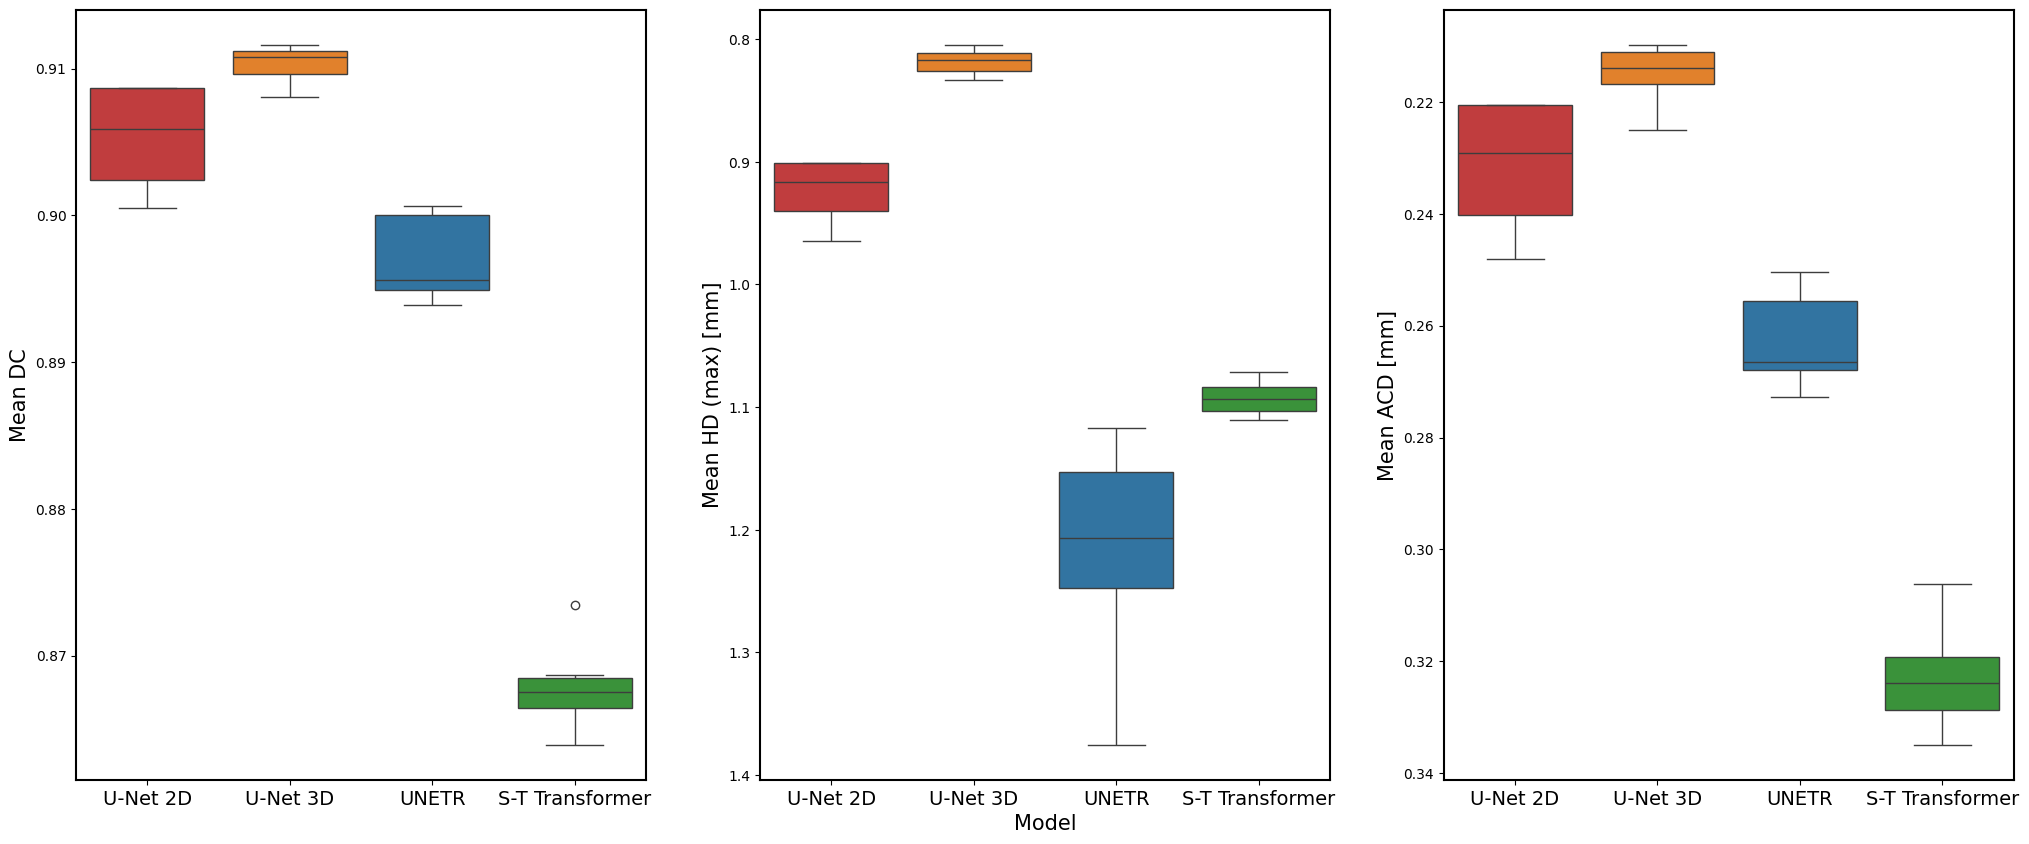

In [24]:
fig, axs = plt.subplots(1,3, figsize=(25,10))
sns.boxplot(
    ax=axs[0],
    data=overall_results.fillna({'T': 0, 'Transform': 'None'}),
    x='Model',
    y='dice_lumen',
    #width=.4,
    hue='Model',
    order=['U-Net 2D','U-Net 3D','UNETR','SpatioTemporalTransformer']
)
axs[0].set(ylabel='Mean DC')
axs[0].set(xlabel='')
axs[0].set_xticklabels([
            'U-Net 2D',
            'U-Net 3D',
            'UNETR',
            'S-T Transformer',
           ], fontsize=14
)

sns.boxplot(
    ax=axs[1],
    data=overall_results.fillna({'T': 0, 'Transform': 'None'}),
    x='Model',
    y='max_hausdorff_distance_lumen',
    #y='hausdorff_distance_lumen',
    #width=.4,
    hue='Model',
    order=['U-Net 2D','U-Net 3D','UNETR','SpatioTemporalTransformer']
)
axs[1].set(ylabel='Mean HD (max) [mm]')
axs[1].set_xticklabels([
            'U-Net 2D',
            'U-Net 3D',
            'UNETR',
            'S-T Transformer',
           ], fontsize=14
)
axs[1].invert_yaxis()

sns.boxplot(
    ax=axs[2],
    data=overall_results.fillna({'T': 0, 'Transform': 'None'}),
    x='Model',
    y='average_contour_distance_lumen',
    #width=.4,
    hue='Model',
    order=['U-Net 2D','U-Net 3D','UNETR','SpatioTemporalTransformer']
)
axs[2].set_ylabel('Mean ACD [mm]')
axs[2].set(xlabel='')
axs[2].set_xticklabels([
            'U-Net 2D',
            'U-Net 3D',
            'UNETR',
            'S-T Transformer',
           ], fontsize=14)
axs[2].invert_yaxis()

save_dir = save_directory / 'ablation'
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_directory / 'ablation'/ 'seg_metrics_boxplot_models_max_hd.svg', bbox_inches='tight')

#### Segmentation Performance by Transform (Validation)

##### All Models excl. nnU-Net, 2D U-Net

In [25]:
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
filter_condition = filtered_df['Transform'].isin(['Interpolate', 'Pad Crop', 'Pad Average'])
filtered_df[filter_condition][['Transform', 'dice_lumen', 'max_hausdorff_distance_lumen', 'average_contour_distance_lumen']].groupby('Transform').mean().round(decimals=3)

,dice_lumen,max_hausdorff_distance_lumen,average_contour_distance_lumen
Transform,,,
Interpolate,0.892,1.054,0.265
Pad Average,0.892,1.015,0.265
Pad Crop,0.891,1.048,0.269


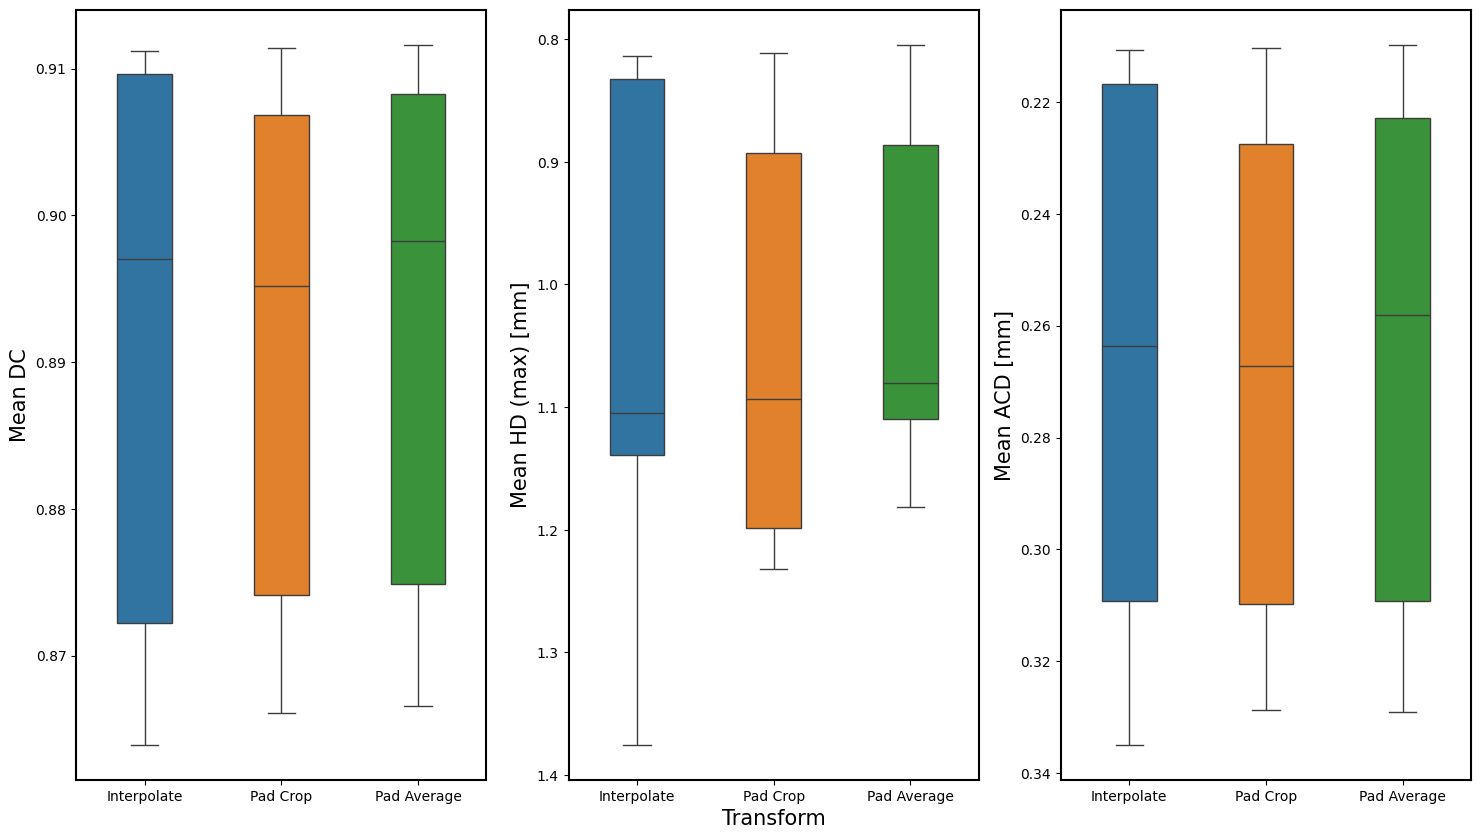

In [26]:
# Overall (interpolate, pad crop, pad average)
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})

select_transforms = [
    'Interpolate',
    'Pad Crop',
    'Pad Average',
]

fig, axs = plt.subplots(1,3,figsize=(18,10))
#plt.figure(figsize=(15,10))
sns.boxplot(
    ax=axs[0],
    data=filtered_df[filtered_df['Transform'].isin(select_transforms)],
    x='Transform',
    y='dice_lumen',
    hue='Transform',
    width=.4
)
axs[0].set(ylabel='Mean DC')
axs[0].set(xlabel='')

sns.boxplot(
    ax=axs[1],
    data=filtered_df[filtered_df['Transform'].isin(select_transforms)],
    x='Transform',
    #y='hausdorff_distance_lumen',
    y='max_hausdorff_distance_lumen',
    hue='Transform',
    width=.4
)
axs[1].set(ylabel='Mean HD (max) [mm]')
axs[1].invert_yaxis()


sns.boxplot(
    ax=axs[2],
    data=filtered_df[filtered_df['Transform'].isin(select_transforms)],
    x='Transform',
    y='average_contour_distance_lumen',
    hue='Transform',
    width=.4
)
axs[2].set(ylabel='Mean ACD [mm]')
axs[2].invert_yaxis()
axs[2].set(xlabel='')

save_dir = save_directory / 'ablation'
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / 'seg_metrics_boxplot_transforms_all_max_hd.svg')

##### All 3D U-Net Models

In [27]:
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
filter_condition = filtered_df['Model'].isin(['U-Net 3D'])
filtered_df[filter_condition][['Transform', 'dice_lumen', 'max_hausdorff_distance_lumen', 'average_contour_distance_lumen']].groupby('Transform').mean().round(decimals=4)

,dice_lumen,max_hausdorff_distance_lumen,average_contour_distance_lumen
Transform,,,
Interpolate,0.9105,0.8245,0.2136
Pad Average,0.9112,0.8140,0.2118
Pad Crop,0.9111,0.8192,0.2123
nnU-Net,0.9085,0.8082,0.2226


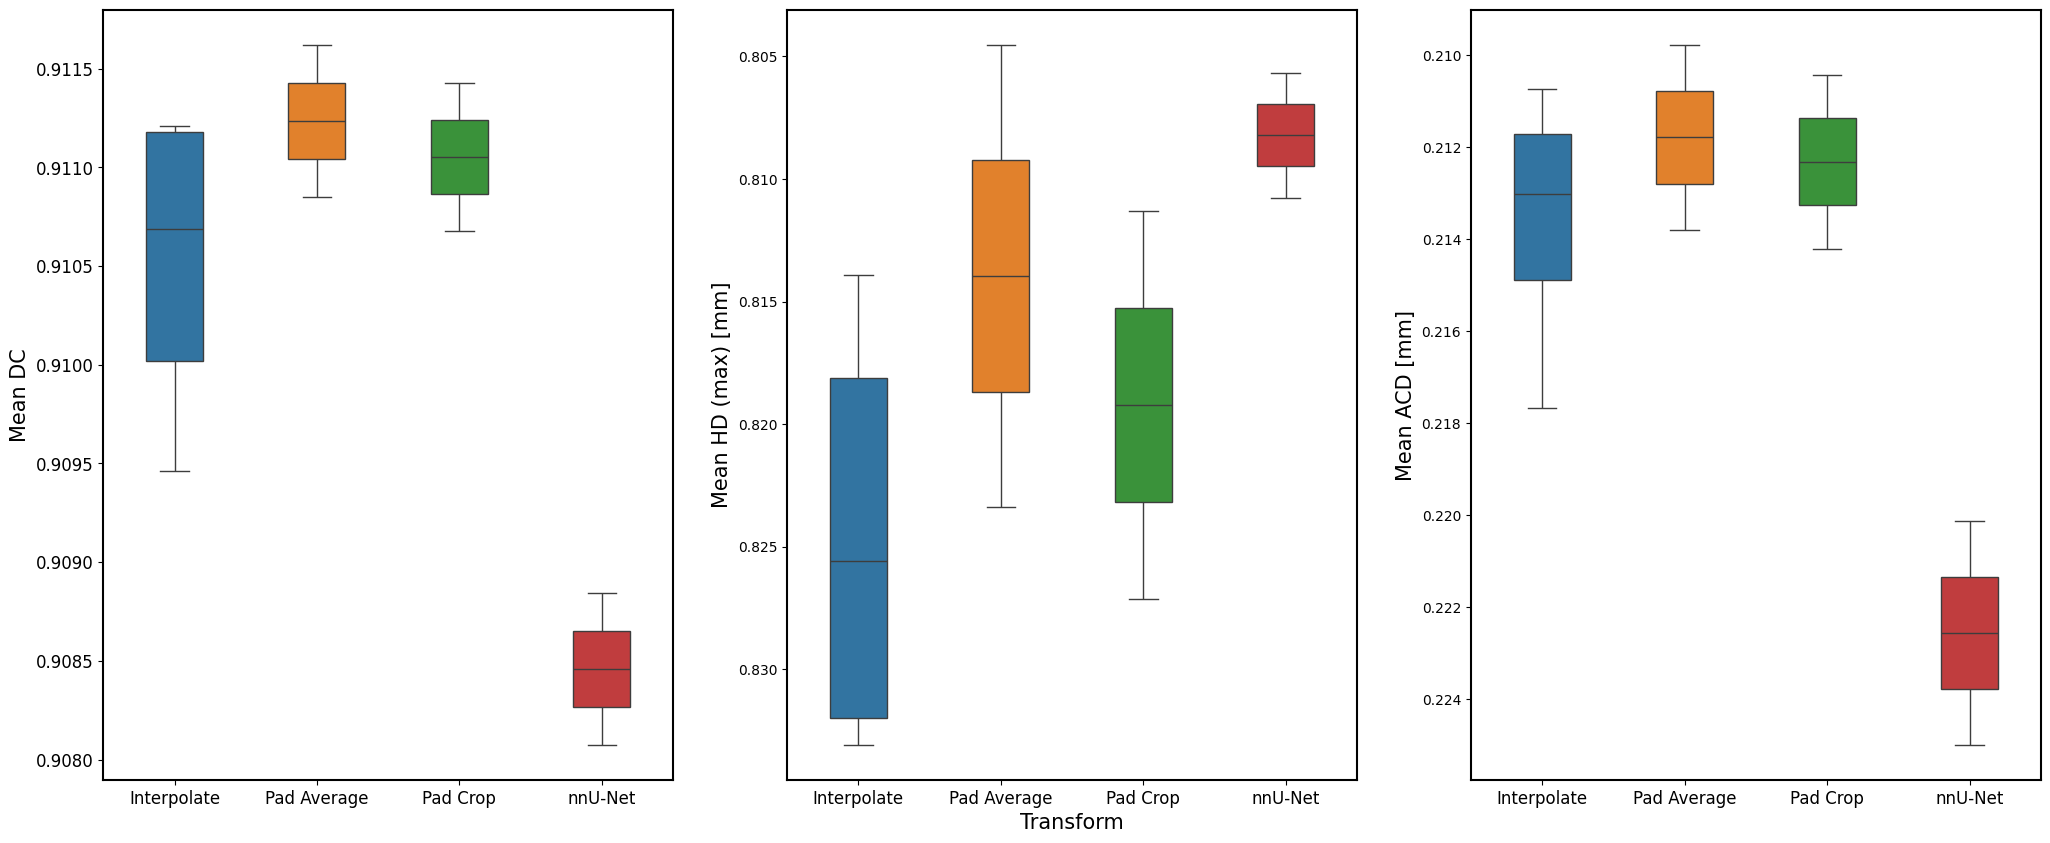

In [28]:
# CNNs only
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})

select_models = [
    #'U-Net 2D',
    'U-Net 3D',
]

select_transforms = [
    'Interpolate',
    'Pad Crop',
    'Pad Average',
    'nnU-Net'
]
filter_condition = filtered_df['Model'].isin(select_models) & filtered_df['Transform'].isin(select_transforms)
fig, axs = plt.subplots(1,3,figsize=(25,10))
#plt.figure(figsize=(15,10))
sns.boxplot(
    ax=axs[0],
    data=filtered_df[filter_condition],
    x='Transform',
    y='dice_lumen',
    hue='Transform',
    width=.4
)
axs[0].set(ylabel='Mean DC')
axs[0].set(xlabel='')
axs[0].tick_params(axis='both', which='major', labelsize=12)

sns.boxplot(
    ax=axs[1],
    data=filtered_df[filter_condition],
    x='Transform',
    #y='hausdorff_distance_lumen',
    y='max_hausdorff_distance_lumen',
    hue='Transform',
    width=.4
)
axs[1].set(ylabel='Mean HD (max) [mm]')
axs[1].invert_yaxis()
axs[1].tick_params(axis='x', which='major', labelsize=12)

sns.boxplot(
    ax=axs[2],
    data=filtered_df[filter_condition],
    x='Transform',
    y='average_contour_distance_lumen',
    hue='Transform',
    width=.4
)
axs[2].set(ylabel='Mean ACD [mm]')
axs[2].invert_yaxis()
axs[2].set(xlabel='')
axs[2].tick_params(axis='x', which='major', labelsize=12)


save_dir = save_directory / 'ablation'
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / 'seg_metrics_boxplot_transforms_cnn_max_hd.svg')

##### All Transformer Models

In [29]:
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
filter_condition = filtered_df['Model'].isin(['UNETR', 'SpatioTemporalTransformer'])
filtered_df[filter_condition][['Transform', 'dice_lumen', 'hausdorff_distance_lumen', 'max_hausdorff_distance_lumen', 'average_contour_distance_lumen']].groupby('Transform').mean().round(decimals=3)

,dice_lumen,hausdorff_distance_lumen,max_hausdorff_distance_lumen,average_contour_distance_lumen
Transform,,,,
Interpolate,0.883,0.947,1.169,0.291
Pad Average,0.883,0.939,1.115,0.292
Pad Crop,0.881,0.967,1.162,0.297


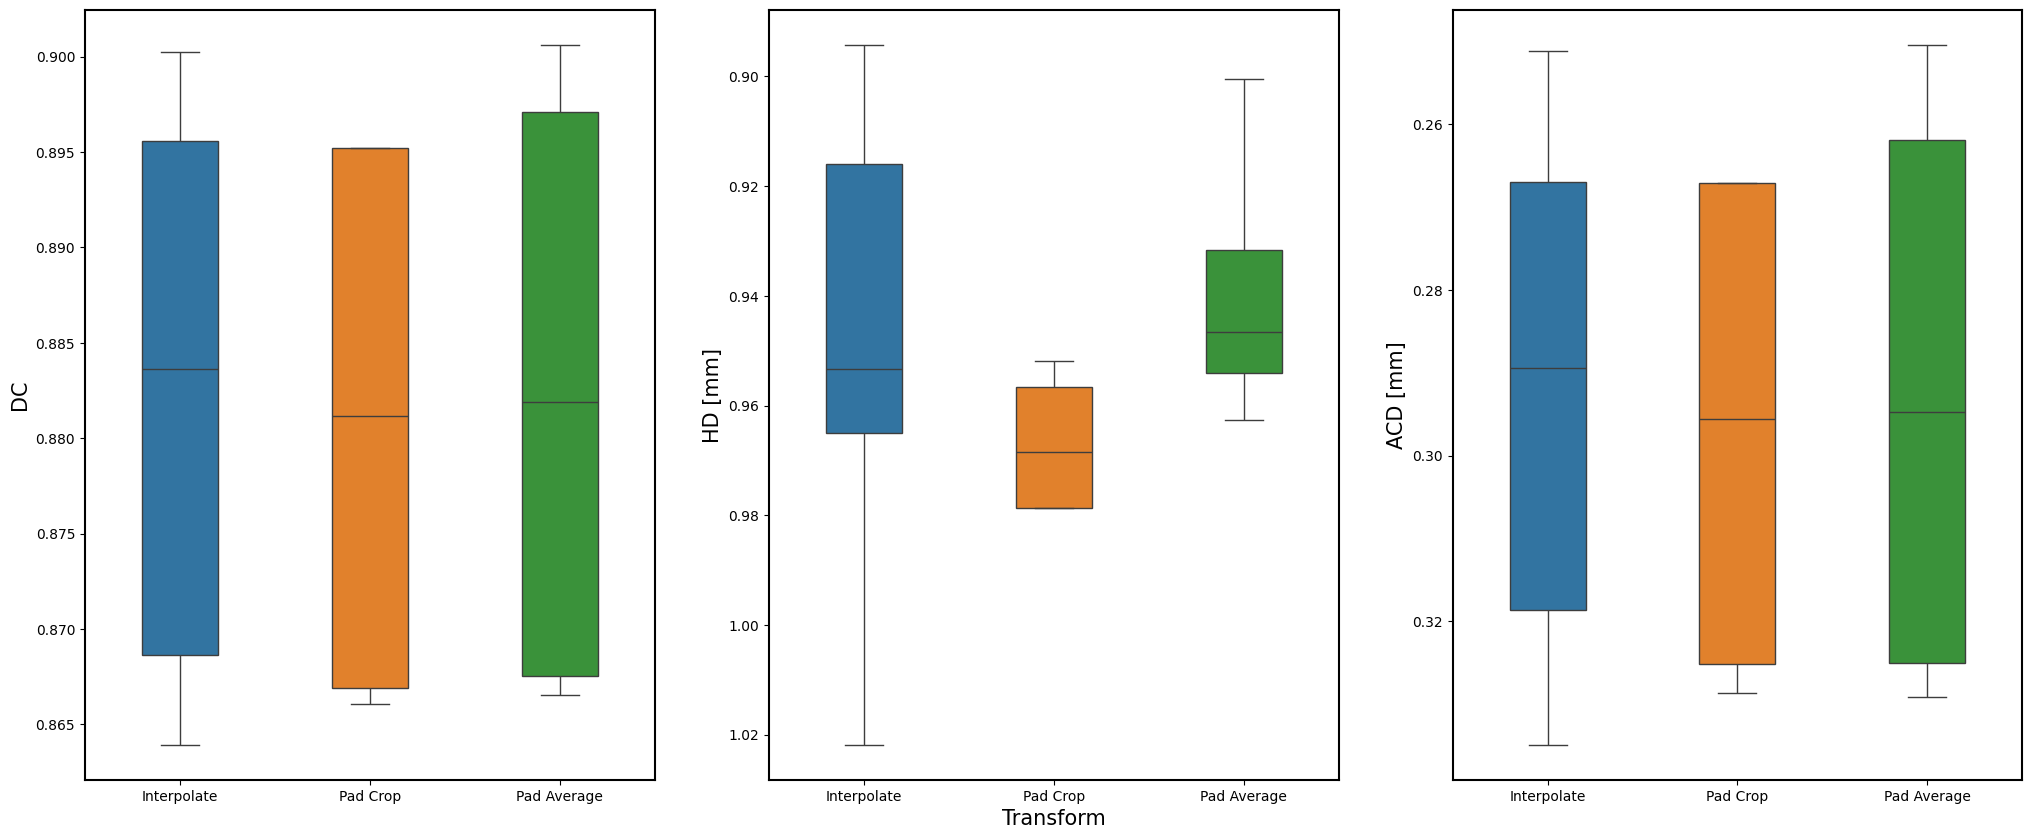

In [30]:
# Transformers only
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})

select_models = [
    'UNETR',
    'SpatioTemporalTransformer',
]

fig, axs = plt.subplots(1,3,figsize=(25,10))
#plt.figure(figsize=(15,10))
sns.boxplot(
    ax=axs[0],
    data=filtered_df[filtered_df['Model'].isin(select_models)],
    x='Transform',
    y='dice_lumen',
    hue='Transform',
    width=.4
)
axs[0].set(ylabel='DC')
axs[0].set(xlabel='')

sns.boxplot(
    ax=axs[1],
    data=filtered_df[filtered_df['Model'].isin(select_models)],
    x='Transform',
    y='hausdorff_distance_lumen',
    hue='Transform',
    width=.4
)
axs[1].set(ylabel='HD [mm]')
axs[1].invert_yaxis()


sns.boxplot(
    ax=axs[2],
    data=filtered_df[filtered_df['Model'].isin(select_models)],
    x='Transform',
    y='average_contour_distance_lumen',
    hue='Transform',
    width=.4
)
axs[2].set(ylabel='ACD [mm]')
axs[2].invert_yaxis()
axs[2].set(xlabel='')

save_dir = save_directory / 'ablation'
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / 'seg_metrics_boxplot_transforms_transformer.svg')

#### Segmentation Performance by Dataset Variant (Validation)

##### All Models

In [31]:
overall_results.fillna({'T': 0, 'Transform': 'None'})[['Dataset', 'dice_lumen', 'max_hausdorff_distance_lumen', 'average_contour_distance_lumen']].groupby('Dataset').mean().round(decimals=3)

,dice_lumen,max_hausdorff_distance_lumen,average_contour_distance_lumen
Dataset,,,
Magnitude,0.894,1.028,0.261
Velocities,0.895,0.995,0.257


<Figure size 640x480 with 0 Axes>

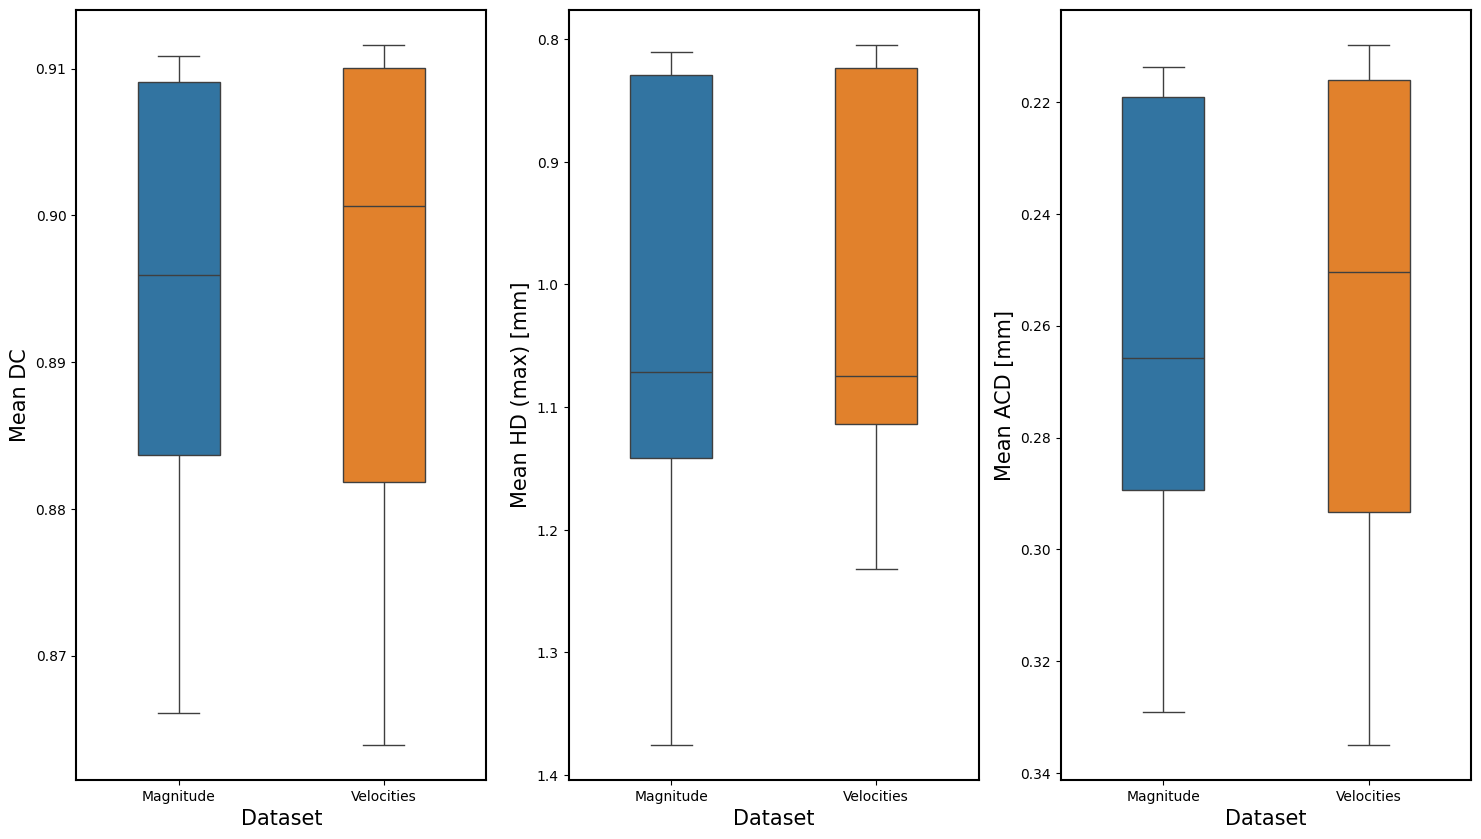

<Figure size 640x480 with 0 Axes>

In [32]:
# Overall performance
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
models = [
    'UNETR',
    'U-Net 3D',
    'SpatioTemporalTransformer',
    'U-Net 2D',
]

plt.figure()
fig, axs = plt.subplots(1,3, figsize=(18,10))
sns.boxplot(
    ax=axs[0],
    data=filtered_df[filtered_df['Model'].isin(models)],
    x='Dataset',
    y='dice_lumen',
    width=.4,
    hue='Dataset',
)
axs[0].set(ylabel='Mean DC')

sns.boxplot(
    ax=axs[1],
    data=filtered_df[filtered_df['Model'].isin(models)],
    x='Dataset',
    y='max_hausdorff_distance_lumen',
    width=.4,
    hue='Dataset',
)
axs[1].set(ylabel='Mean HD (max) [mm]')
axs[1].invert_yaxis()

sns.boxplot(
    ax=axs[2],
    data=filtered_df[filtered_df['Model'].isin(models)],
    x='Dataset',
    y='average_contour_distance_lumen',
    width=.4,
    hue='Dataset',
)
axs[2].set(ylabel='Mean ACD [mm]')
axs[2].invert_yaxis()
save_dir = save_directory / 'ablation'
save_dir.mkdir(exist_ok=True, parents=True)
plt.show()
plt.savefig(save_dir / 'seg_metrics_boxplot_datasets.svg')

##### All 3D U-Net Models

<Figure size 640x480 with 0 Axes>

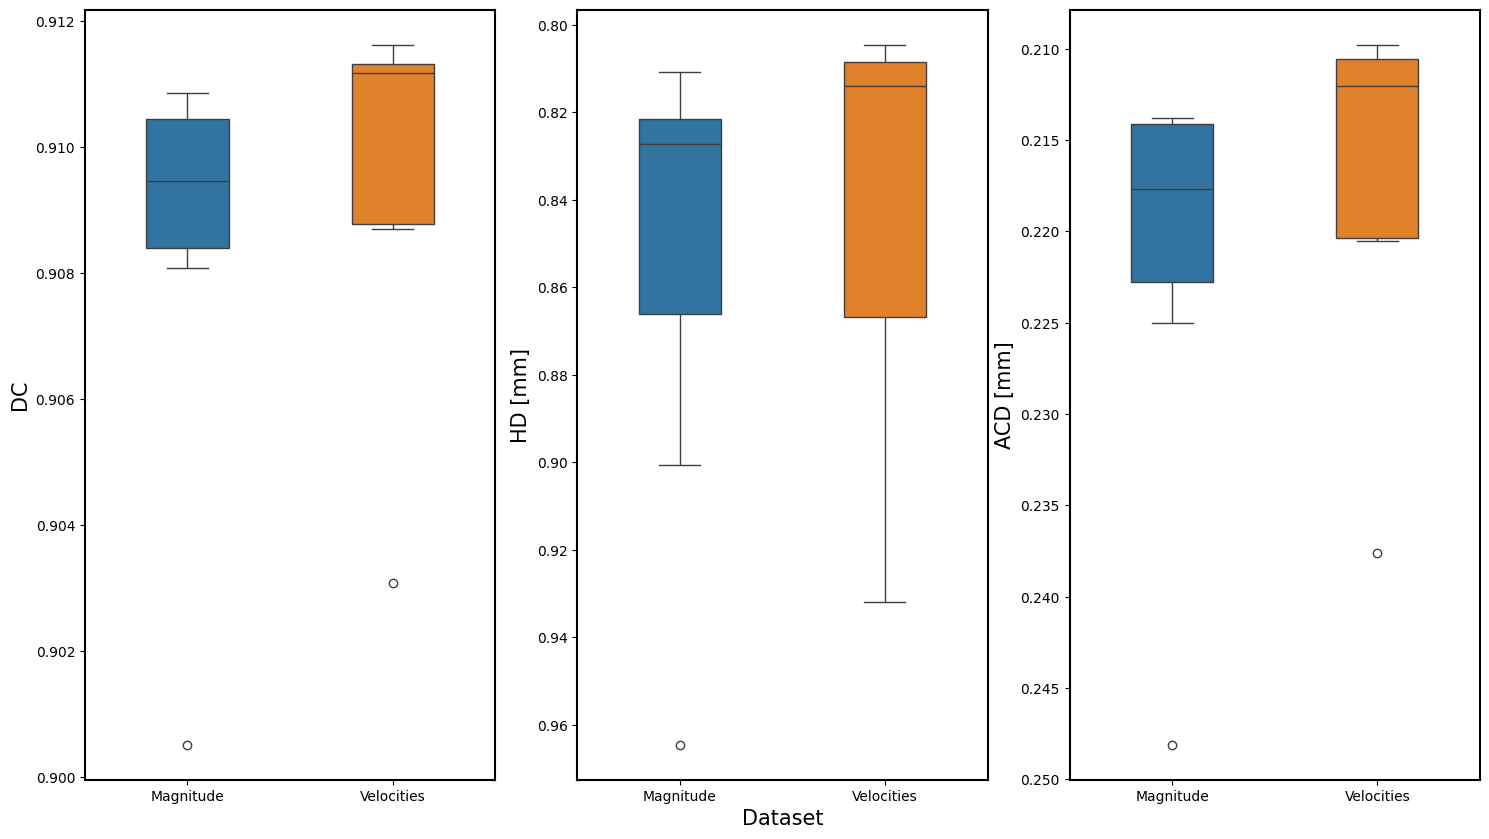

In [33]:
# CNNs only
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
models = [
    #'UNETR',
    'U-Net 3D',
    'U-Net 2D',
]

plt.figure()
fig, axs = plt.subplots(1,3, figsize=(18,10))
sns.boxplot(
    ax=axs[0],
    data=filtered_df[filtered_df['Model'].isin(models)],
    x='Dataset',
    y='dice_lumen',
    width=.4,
    hue='Dataset',
)
axs[0].set(ylabel='DC')
axs[0].set(xlabel='')

sns.boxplot(
    ax=axs[1],
    data=filtered_df[filtered_df['Model'].isin(models)],
    x='Dataset',
    y='max_hausdorff_distance_lumen',
    width=.4,
    hue='Dataset',
)
axs[1].set(ylabel='HD [mm]')
axs[1].invert_yaxis()

sns.boxplot(
    ax=axs[2],
    data=filtered_df[filtered_df['Model'].isin(models)],
    x='Dataset',
    y='average_contour_distance_lumen',
    width=.4,
    hue='Dataset',
)
axs[2].set(ylabel='ACD [mm]')
axs[2].set(xlabel='')
axs[2].invert_yaxis()
save_dir = save_directory / 'ablation'
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / 'seg_metrics_boxplot_cnn.svg')

##### All Transformer Models

<Figure size 640x480 with 0 Axes>

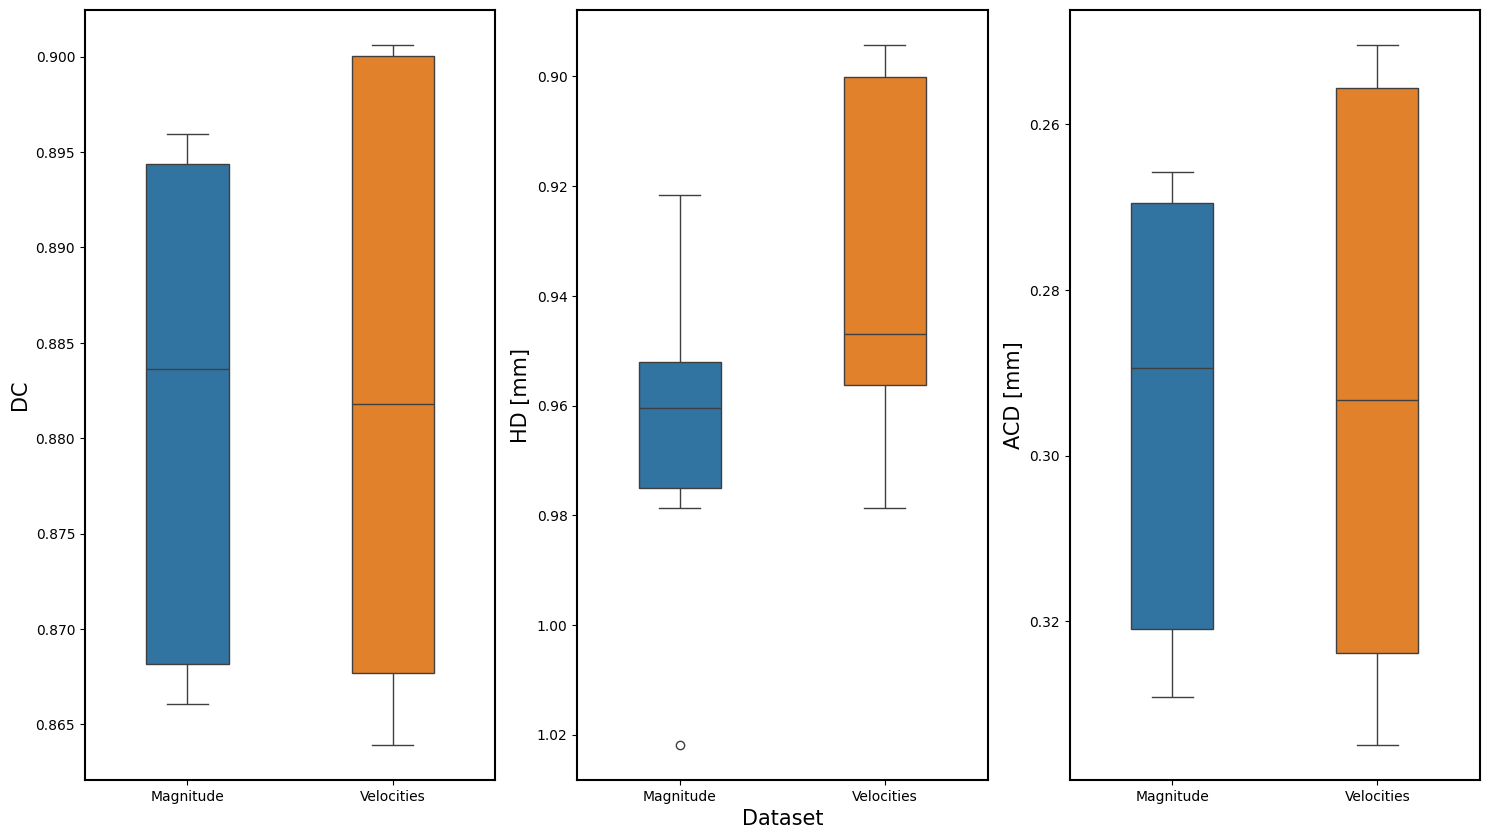

In [34]:
# Transformers only
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
models = [
    'UNETR',
    'SpatioTemporalTransformer',
]

plt.figure()
fig, axs = plt.subplots(1,3, figsize=(18,10))
sns.boxplot(
    ax=axs[0],
    data=filtered_df[filtered_df['Model'].isin(models)],
    x='Dataset',
    y='dice_lumen',
    width=.4,
    hue='Dataset',
)
axs[0].set(ylabel='DC')
axs[0].set(xlabel='')

sns.boxplot(
    ax=axs[1],
    data=filtered_df[filtered_df['Model'].isin(models)],
    x='Dataset',
    y='hausdorff_distance_lumen',
    width=.4,
    hue='Dataset',
)
axs[1].set(ylabel='HD [mm]')
axs[1].invert_yaxis()

sns.boxplot(
    ax=axs[2],
    data=filtered_df[filtered_df['Model'].isin(models)],
    x='Dataset',
    y='average_contour_distance_lumen',
    width=.4,
    hue='Dataset',
)
axs[2].set(ylabel='ACD [mm]')
axs[2].set(xlabel='')
axs[2].invert_yaxis()
save_dir = save_directory / 'ablation'
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / 'seg_metrics_boxplot_transformers.svg')

#### Parameter Prediction by Model (Validation)

##### All Models

In [35]:
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
filtered_df[['Model', 'icc_lumen_diameter', 'icc_flow_rate', 'icc_max_velocity']].groupby('Model').mean().round(decimals=3)

,icc_lumen_diameter,icc_flow_rate,icc_max_velocity
Model,,,
SpatioTemporalTransformer,0.868,0.974,0.937
U-Net 2D,0.925,0.987,0.966
U-Net 3D,0.943,0.988,0.968
UNETR,0.922,0.982,0.957


/tmp/ipykernel_3576228/374681882.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_3576228/374681882.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels([
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_3576228/374681882.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels([


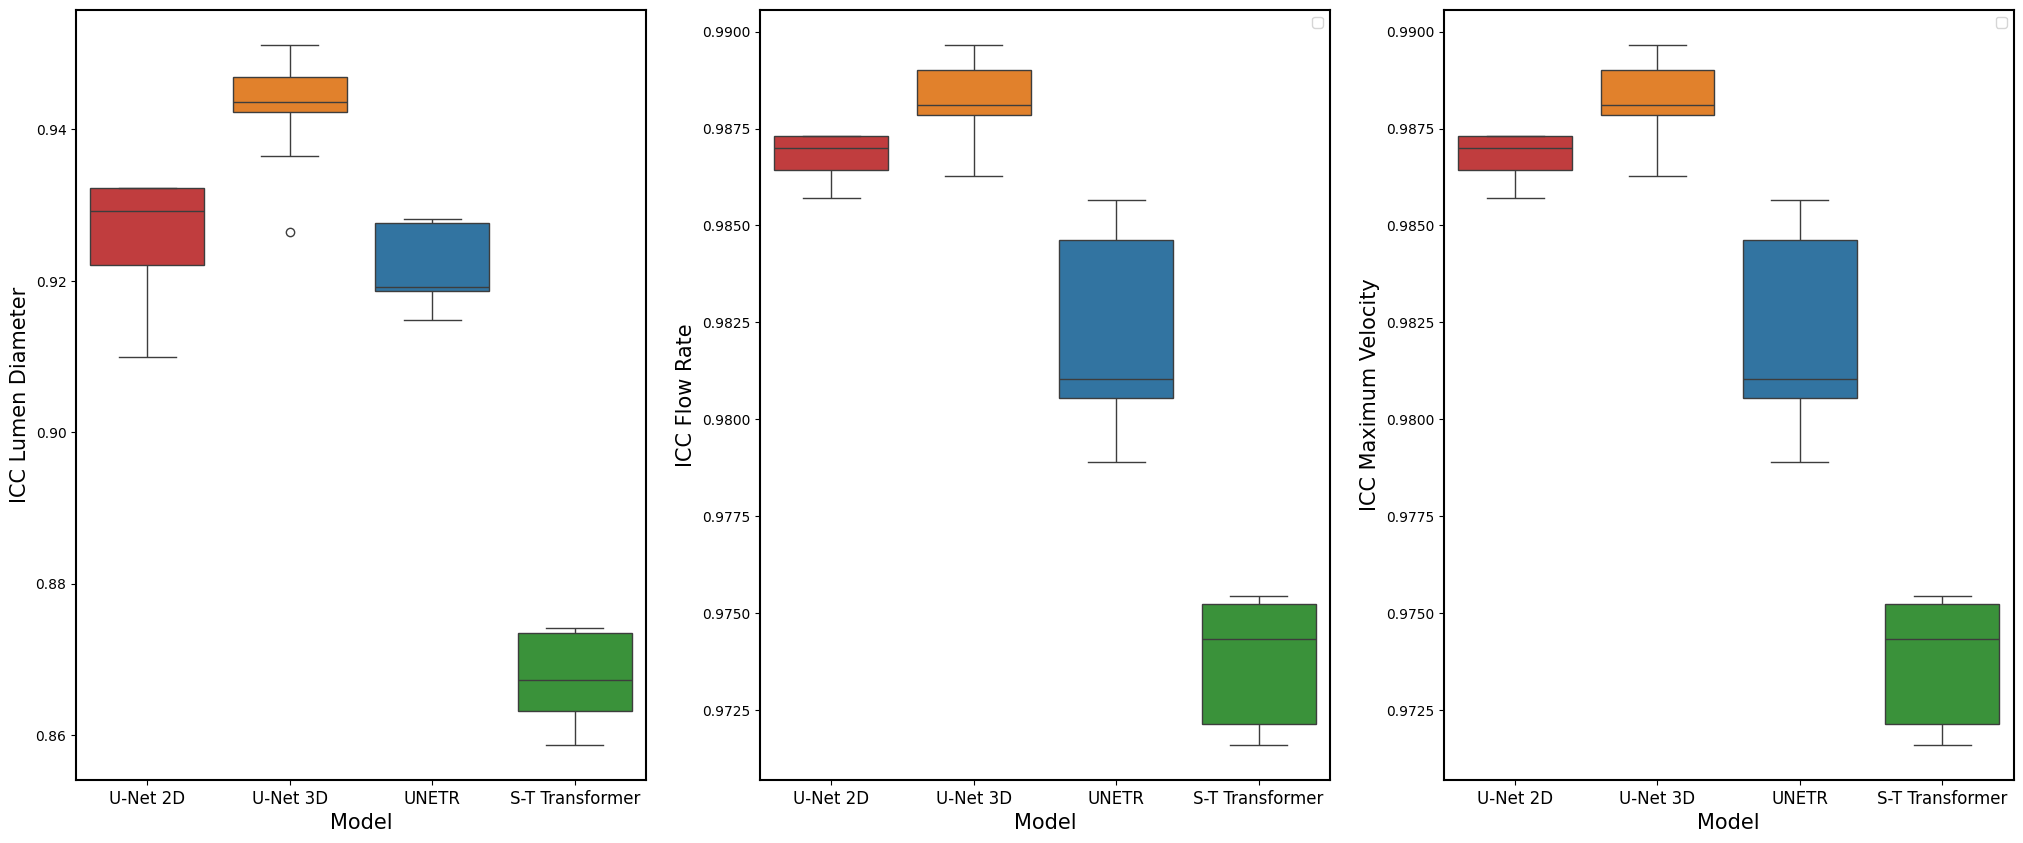

In [36]:
tmp_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
fig, axs = plt.subplots(1,3, figsize=(25,10))
sns.boxplot(
    ax=axs[0],
    data=tmp_df,
    x='Model',
    y='icc_lumen_diameter',
    order=['U-Net 2D','U-Net 3D','UNETR','SpatioTemporalTransformer'],
    hue='Model',
)
axs[0].set(ylabel='ICC Lumen Diameter')
axs[0].set(ylabel='ICC Lumen Diameter')
axs[0].set_xticklabels([
    'U-Net 2D',
    'U-Net 3D',
    'UNETR',
    'S-T Transformer'
    ], fontsize=12
      )
sns.boxplot(
    ax=axs[1],
    data=tmp_df,
    x='Model',
    y='icc_flow_rate',
    order=['U-Net 2D','U-Net 3D','UNETR','SpatioTemporalTransformer'],
    hue='Model',
)
axs[1].set(ylabel='ICC Flow Rate')
axs[1].legend()
axs[1].set_xticklabels([
    'U-Net 2D',
    'U-Net 3D',
    'UNETR',
    'S-T Transformer',
], fontsize=12)
sns.boxplot(
    ax=axs[2],
    data=tmp_df,
    x='Model',
    y='icc_flow_rate',
    order=['U-Net 2D','U-Net 3D','UNETR','SpatioTemporalTransformer'],
    hue='Model',
)
axs[2].set(ylabel='ICC Maximum Velocity')
axs[2].legend()
axs[2].set_xticklabels([
    'U-Net 2D',
    'U-Net 3D',
    'UNETR',
    'S-T Transformer',
], fontsize=12)
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / 'icc_boxplot_models.svg')

#### Parameter Prediction by Dataset Variant (Validation)

##### All Models

In [37]:
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
filtered_df[['Dataset', 'icc_lumen_diameter', 'icc_flow_rate', 'icc_max_velocity']].groupby('Dataset').mean().round(decimals=4)

,icc_lumen_diameter,icc_flow_rate,icc_max_velocity
Dataset,,,
Magnitude,0.9118,0.9817,0.957
Velocities,0.9176,0.9835,0.956


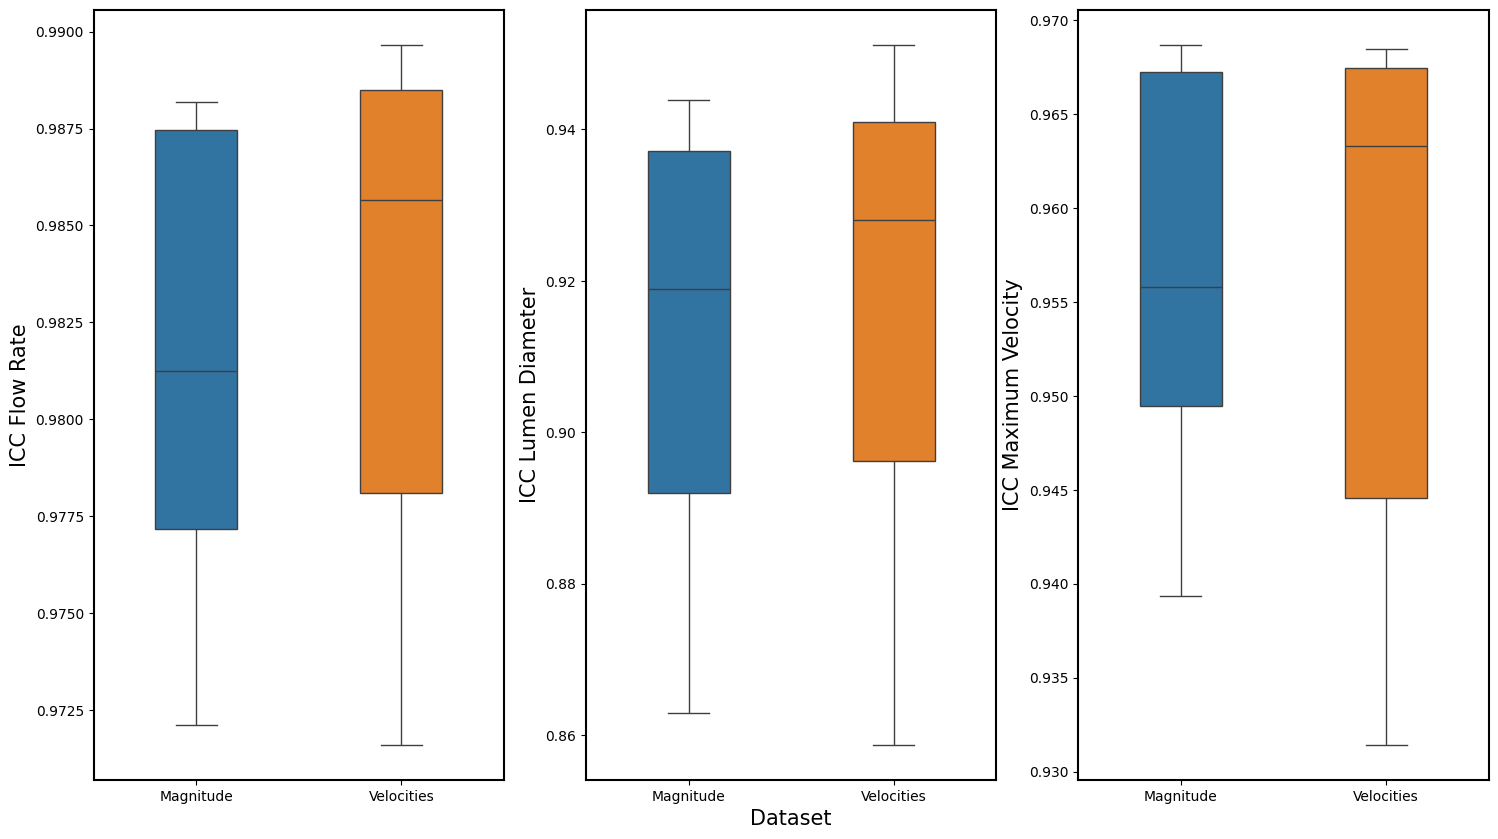

In [38]:
# All models
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})


fig, axs = plt.subplots(1,3, figsize=(18,10))
sns.boxplot(
    ax=axs[0],
    data=filtered_df,
    x='Dataset',
    y='icc_flow_rate',
    hue='Dataset',
    width=.4,
    legend=None,
)
sns.boxplot(
    ax=axs[1],
    data=filtered_df,
    x='Dataset',
    y='icc_lumen_diameter',
    hue='Dataset',
    width=.4,
)
sns.boxplot(
    ax=axs[2],
    data=filtered_df,
    x='Dataset',
    y='icc_max_velocity',
    hue='Dataset',
    width=.4,
)
axs[0].set(ylabel='ICC Flow Rate')
axs[0].set(xlabel='')
axs[1].set(ylabel='ICC Lumen Diameter')
axs[2].set(ylabel='ICC Maximum Velocity')
axs[2].set(xlabel='')
save_dir = save_directory / 'ablation'
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / 'icc_boxplot_datasets.svg')

##### All 3D U-Net Models

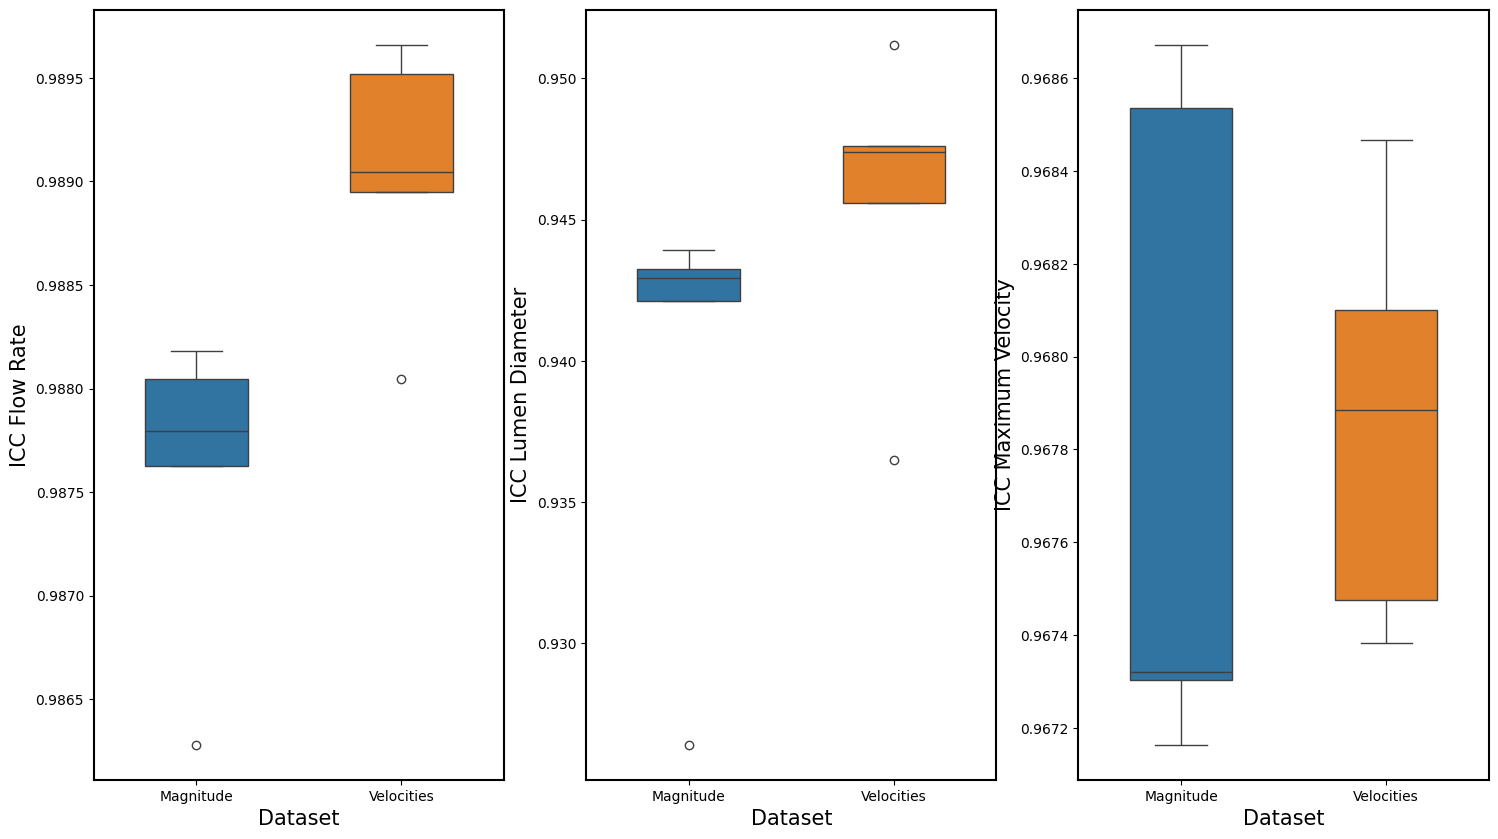

In [39]:
# U-Net only
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})

select_models = [
    'U-Net 3D',
]


filter_condition = filtered_df['Model'].isin(select_models)

fig, axs = plt.subplots(1,3, figsize=(18,10))
sns.boxplot(
    ax=axs[0],
    data=filtered_df[filter_condition],
    x='Dataset',
    y='icc_flow_rate',
    hue='Dataset',
    width=.5,
    #s=10,
    #alpha=.7,
    legend=None,
)
sns.boxplot(
    ax=axs[1],
    data=filtered_df[filter_condition],
    x='Dataset',
    y='icc_lumen_diameter',
    hue='Dataset',
    width=.5,
)
sns.boxplot(
    ax=axs[2],
    data=filtered_df[filter_condition],
    x='Dataset',
    y='icc_max_velocity',
    hue='Dataset',
    width=.5,
)
axs[0].set(ylabel='ICC Flow Rate')
axs[1].set(ylabel='ICC Lumen Diameter')
axs[2].set(ylabel='ICC Maximum Velocity')
save_dir = save_directory / 'ablation'
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / 'icc_boxplot_datasets_cnn.svg')

##### All Transformer Models

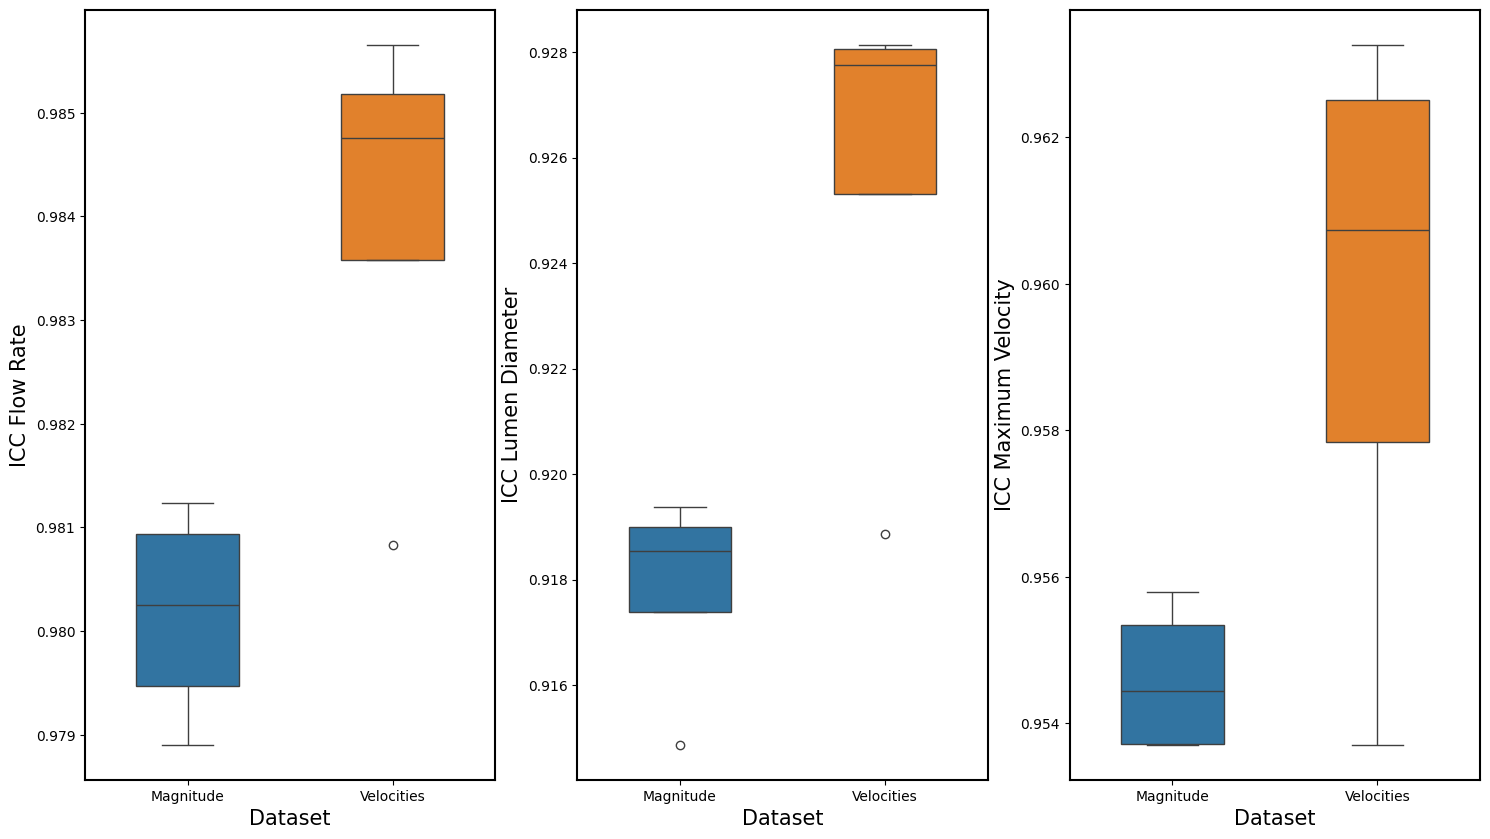

In [40]:
# Transformers only
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})

select_models = [
    'UNETR',
    'Spatio-Temporal Transformer',
]


filter_condition = filtered_df['Model'].isin(select_models)

fig, axs = plt.subplots(1,3, figsize=(18,10))
sns.boxplot(
    ax=axs[0],
    data=filtered_df[filter_condition],
    x='Dataset',
    y='icc_flow_rate',
    hue='Dataset',
    width=.5,
    legend=None,
)
sns.boxplot(
    ax=axs[1],
    data=filtered_df[filter_condition],
    x='Dataset',
    y='icc_lumen_diameter',
    hue='Dataset',
    width=.5,
)
sns.boxplot(
    ax=axs[2],
    data=filtered_df[filter_condition],
    x='Dataset',
    y='icc_max_velocity',
    hue='Dataset',
    width=.5,
)
axs[0].set(ylabel='ICC Flow Rate')
axs[1].set(ylabel='ICC Lumen Diameter')
axs[2].set(ylabel='ICC Maximum Velocity')
save_dir = save_directory / 'ablation'
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / 'icc_boxplot_datasets_transformer.svg')

##### All Models excl. nnU-Net, 2D U-Net

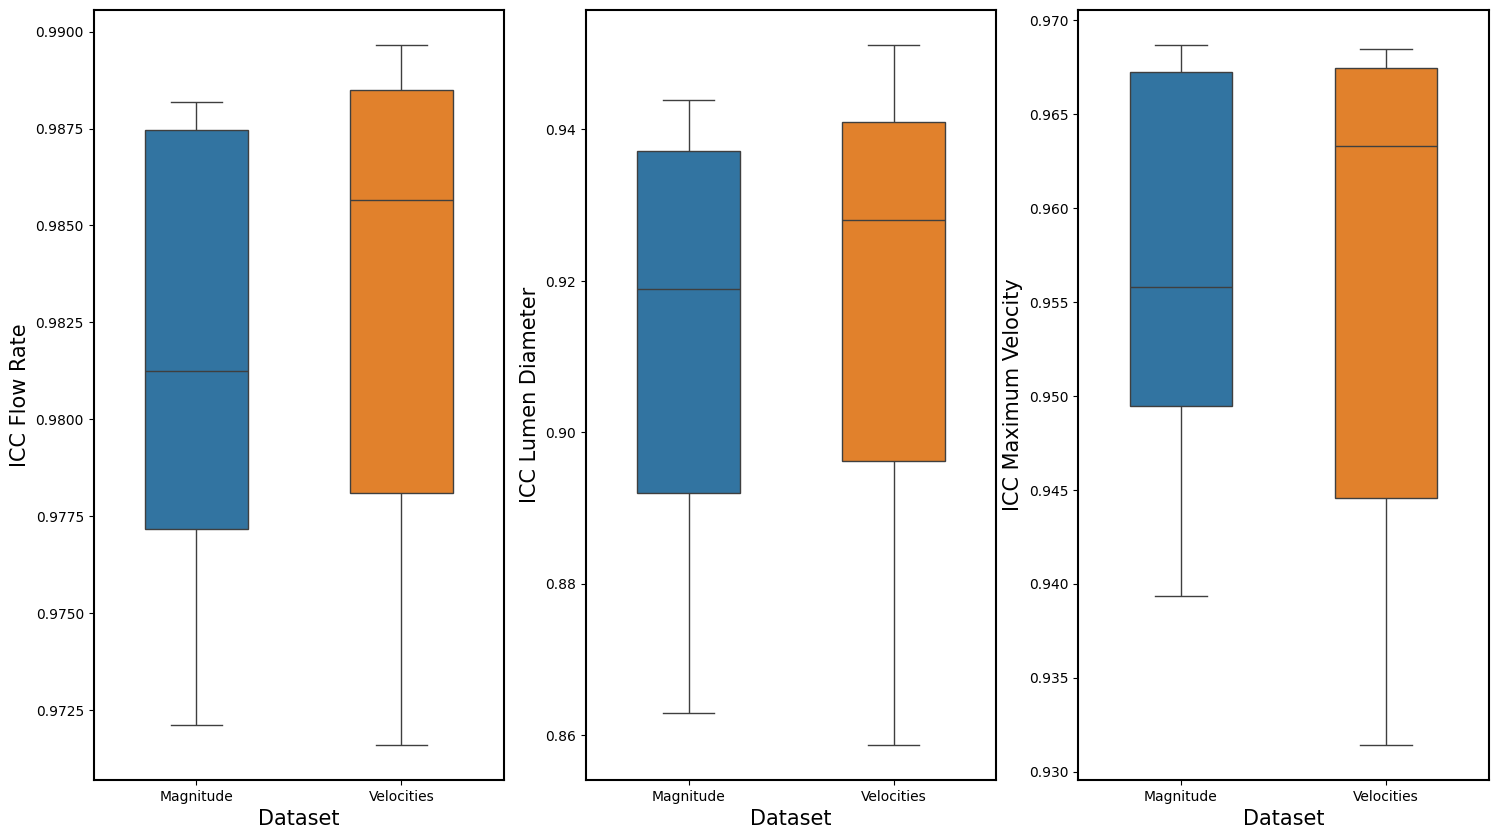

In [41]:
select_models = [
    'Interpolate',
    'Pad Crop',
    'Pad Average',
]

condition = tmp_df['Transform'].isin(select_models)

fig, axs = plt.subplots(1,3, figsize=(18,10))
sns.boxplot(
    ax=axs[0],
    data=overall_results.fillna({'T': 0, 'Transform': 'None'}),
    x='Dataset',
    y='icc_flow_rate',
    hue='Dataset',
    width=.5,
    legend=None,
)
sns.boxplot(
    ax=axs[1],
    data=overall_results.fillna({'T': 0, 'Transform': 'None'}),
    x='Dataset',
    y='icc_lumen_diameter',
    hue='Dataset',
    width=.5,
)
sns.boxplot(
    ax=axs[2],
    data=overall_results.fillna({'T': 0, 'Transform': 'None'}),
    x='Dataset',
    y='icc_max_velocity',
    hue='Dataset',
    width=.5,
)
axs[0].set(ylabel='ICC Flow Rate')
axs[1].set(ylabel='ICC Lumen Diameter')
axs[2].set(ylabel='ICC Maximum Velocity')
save_dir = save_directory / 'ablation'
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / 'icc_boxplot_datasets_excl_nnunet.svg')

#### Parameter Prediction by Transform (Validation)

##### All Models excl. nnU-Net, 2D U-Net

In [42]:
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
filter_condition = filtered_df['Transform'].isin(['Interpolate', 'Pad Crop', 'Pad Average'])
filtered_df[filter_condition][['Transform', 'icc_lumen_diameter', 'icc_flow_rate', 'icc_max_velocity']].groupby('Transform').mean().round(decimals=3)

,icc_lumen_diameter,icc_flow_rate,icc_max_velocity
Transform,,,
Interpolate,0.912,0.982,0.955
Pad Average,0.912,0.982,0.954
Pad Crop,0.911,0.981,0.952


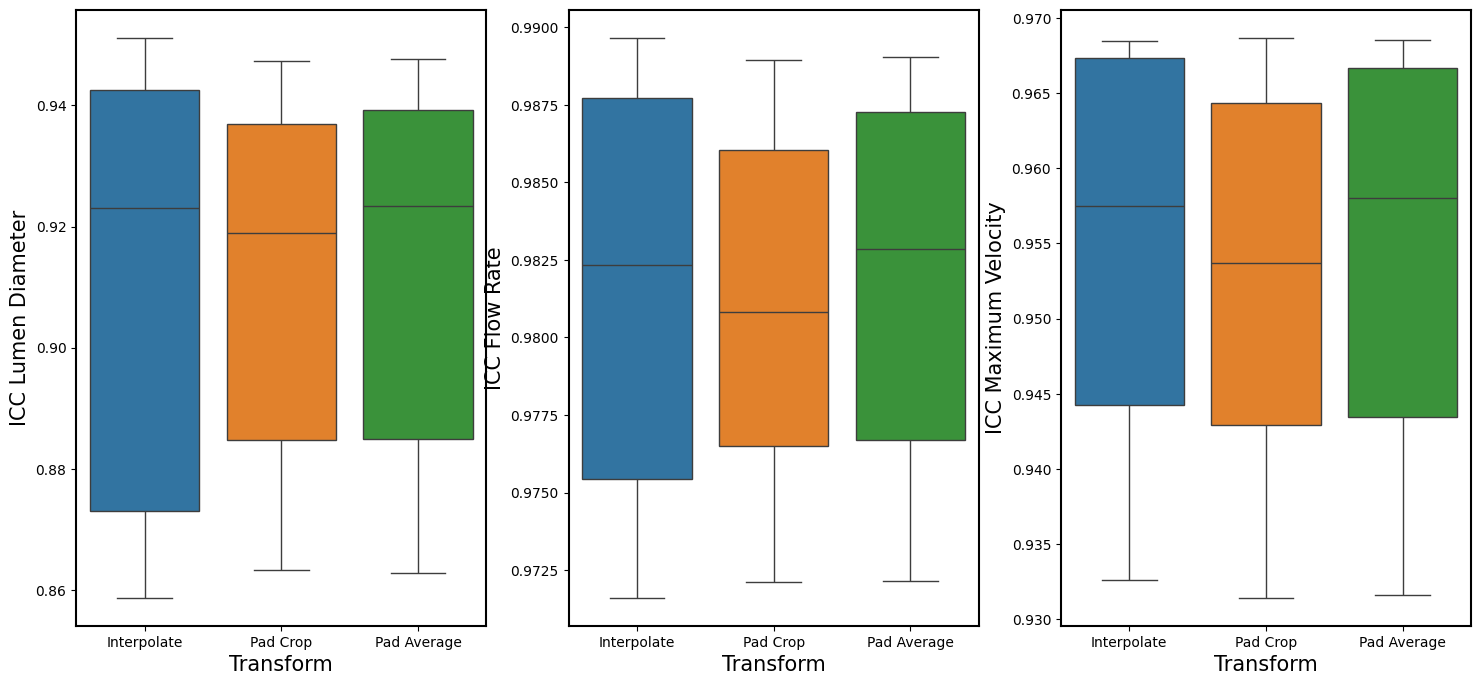

In [43]:
tmp_df = overall_results.fillna({'T': 0, 'Transform': 'None'})

select_transforms = [
    'Interpolate',
    'Pad Crop',
    'Pad Average',
]

condition = tmp_df['Transform'].isin(select_transforms)

fig, axs = plt.subplots(1,3, figsize=(18,8))
sns.boxplot(
    ax=axs[0],
    data=tmp_df[condition],
    x='Transform',
    y='icc_lumen_diameter',
    hue='Transform',
)
axs[0].set(ylabel='ICC Lumen Diameter')

sns.boxplot(
    ax=axs[1],
    data=tmp_df[condition],
    x='Transform',
    y='icc_flow_rate',
    hue='Transform',
)
axs[1].set(ylabel='ICC Flow Rate')

sns.boxplot(
    ax=axs[2],
    data=tmp_df[condition],
    x='Transform',
    y='icc_max_velocity',
    hue='Transform',
)
axs[2].set(ylabel='ICC Maximum Velocity')

save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / 'icc_boxplot_transforms.svg')

##### All 3D U-Net Models

In [44]:
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
filter_condition = filtered_df['Model'].isin(['U-Net 3D'])
filtered_df[filter_condition][['Transform', 'icc_lumen_diameter', 'icc_flow_rate', 'icc_max_velocity']].groupby('Transform').mean().round(decimals=3)

,icc_lumen_diameter,icc_flow_rate,icc_max_velocity
Transform,,,
Interpolate,0.946,0.989,0.968
Pad Average,0.945,0.989,0.968
Pad Crop,0.945,0.988,0.968
nnU-Net,0.931,0.987,0.967


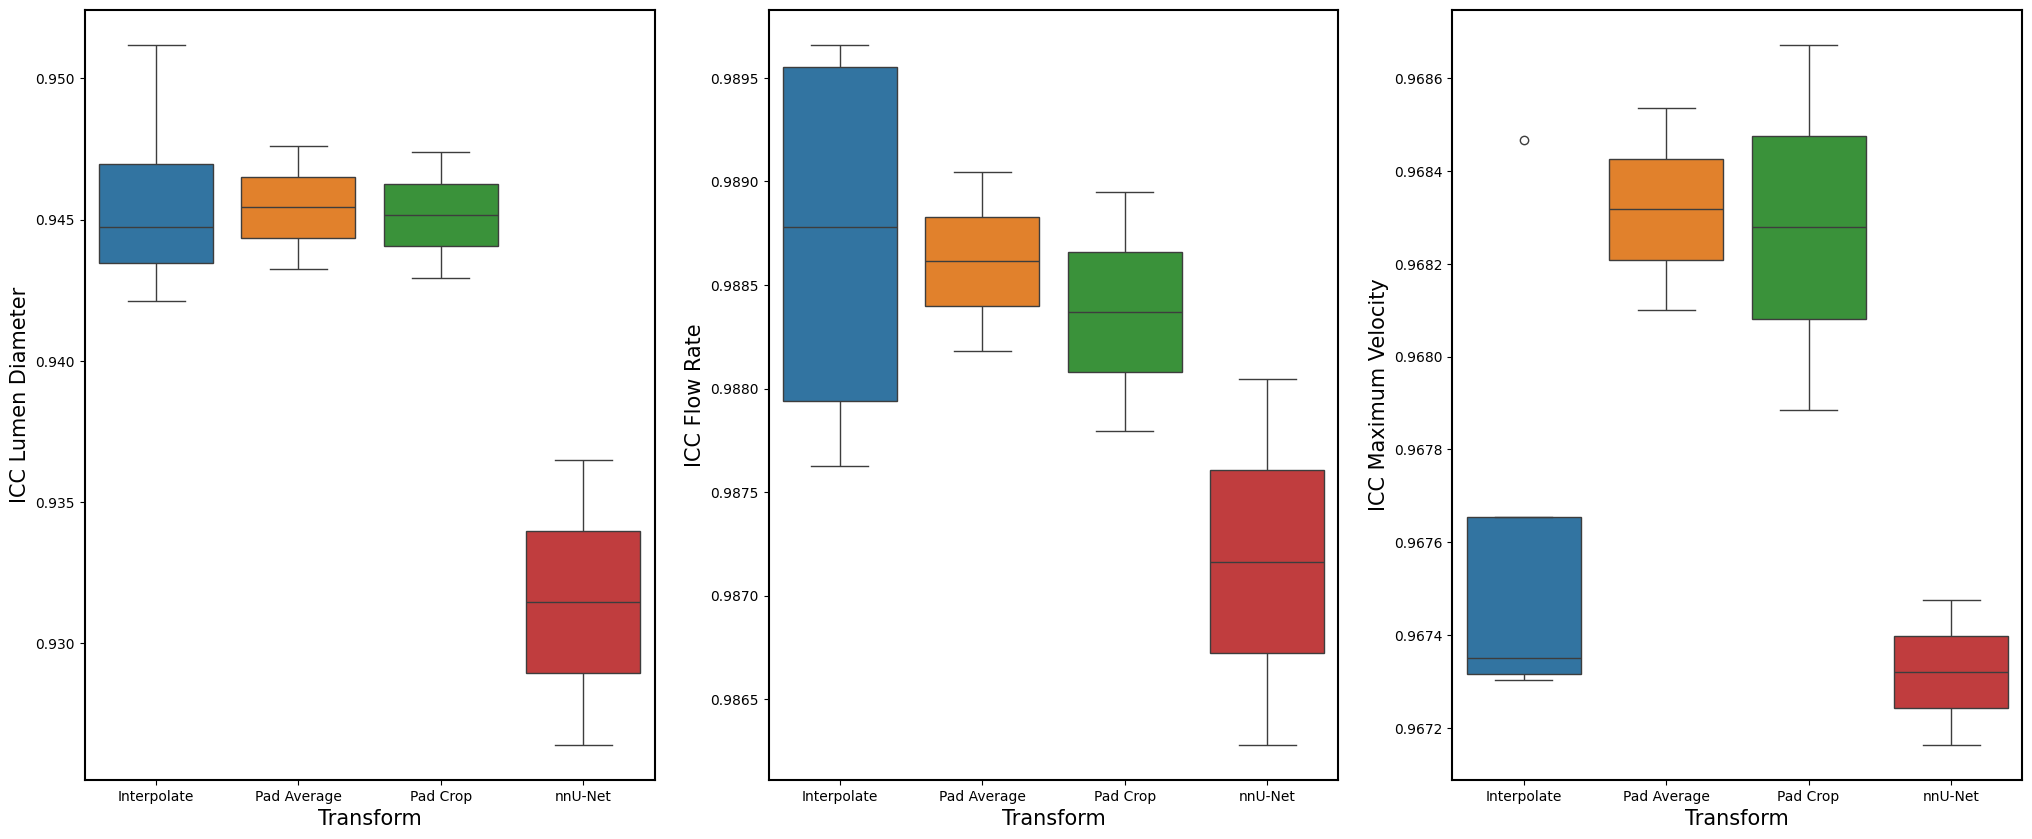

In [45]:
# CNN models
tmp_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
fig, axs = plt.subplots(1,3, figsize=(25,10))
models = [
    'U-Net 3D',
]
sns.boxplot(
    ax=axs[0],
    data=tmp_df[tmp_df['Model'].isin(models)],
    x='Transform',
    y='icc_lumen_diameter',
    hue='Transform',
)
axs[0].set(ylabel='ICC Lumen Diameter')

sns.boxplot(
    ax=axs[1],
    data=tmp_df[tmp_df['Model'].isin(models)],
    x='Transform',
    y='icc_flow_rate',
    hue='Transform',
)
axs[1].set(ylabel='ICC Flow Rate')

sns.boxplot(
    ax=axs[2],
    data=tmp_df[tmp_df['Model'].isin(models)],
    x='Transform',
    y='icc_max_velocity',
    hue='Transform',
)
axs[2].set(ylabel='ICC Maximum Velocity')

save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / 'icc_boxplot_transforms_cnn.svg')

##### All Transformer Models

In [46]:
filtered_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
filter_condition = filtered_df['Model'].isin(['UNETR', 'SpatioTemporalTransformer'])
filtered_df[filter_condition][['Transform', 'icc_lumen_diameter', 'icc_flow_rate', 'icc_max_velocity']].groupby('Transform').mean().round(decimals=3)

,icc_lumen_diameter,icc_flow_rate,icc_max_velocity
Transform,,,
Interpolate,0.895,0.978,0.949
Pad Average,0.896,0.978,0.947
Pad Crop,0.894,0.977,0.945


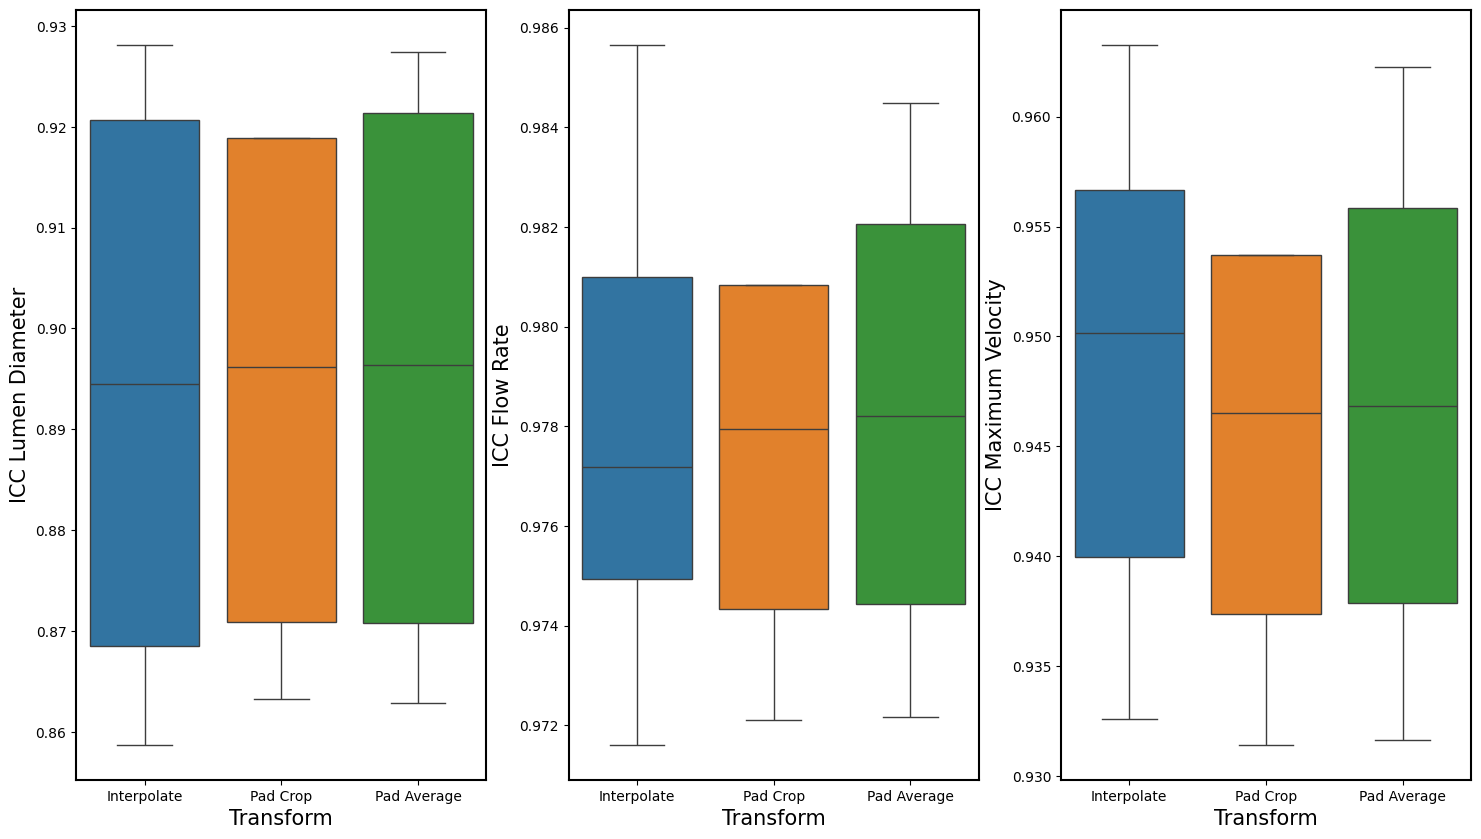

In [47]:
# Transformer models
tmp_df = overall_results.fillna({'T': 0, 'Transform': 'None'})
fig, axs = plt.subplots(1,3, figsize=(18,10))
models = [
    'UNETR',
    'SpatioTemporalTransformer',
]
sns.boxplot(
    ax=axs[0],
    data=tmp_df[tmp_df['Model'].isin(models)],
    x='Transform',
    y='icc_lumen_diameter',
    hue='Transform',
)
axs[0].set(ylabel='ICC Lumen Diameter')

sns.boxplot(
    ax=axs[1],
    data=tmp_df[tmp_df['Model'].isin(models)],
    x='Transform',
    y='icc_flow_rate',
    hue='Transform',
)
axs[1].set(ylabel='ICC Flow Rate')

sns.boxplot(
    ax=axs[2],
    data=tmp_df[tmp_df['Model'].isin(models)],
    x='Transform',
    y='icc_max_velocity',
    hue='Transform',
)
axs[2].set(ylabel='ICC Maximum Velocity')

save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(Path(save_dir) / 'icc_boxplot_transforms_transformer.svg')